<a href="https://colab.research.google.com/github/yinghaow525/MSBA-Projects/blob/main/Capstone%20Project/Capstone_A6_Coding_Deliverable_03_Time_Series_Foracasting_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capsone Project with Spinnaker Analytics
Team A6: Yihan Jia, Yinghao Wang, Simeng Li, Xiangshan Mu, Kaiyu Wang
> **Business Objectives**:
- The objective of the exercise is to find a tradable signal in the dataset. 

> **Project Flow**:
- Standard time series models can be used or non-parametric models like neural networks can be deployed. Suggested course of actions is as follows:
  1. Understand the dataset and what it represents
  2. Define the problem: what does 'a tradable signal' mean based on the data available (i.e. develop your modeling equation, if any)
  3. Start with simple analysis to identify patterns and outliers
  4. Develop models with increasing complexity - i.e. don't start with neural nets etc
  5. Define your success criteria - i.e. when do you know you have a tradable signal - positive (buy)/negative (sell), both are signals


In [ ]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.api import ExponentialSmoothing

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from statsmodels.tsa.arima_model import ARIMA



from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, neural_network
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support

#reset recursionlimit
import sys
sys.setrecursionlimit(10000)

import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

# supress filter warnings
import warnings
warnings.filterwarnings("ignore")

#plt style
plt.style.use("seaborn")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# read datasets
ETF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Inst%20ETF.csv')
IMF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Institutional%20MF.csv')
RMF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Retail%20MF.csv')

# Concating & Preprocessing

In [ ]:
# Create type colunm
ETF['Type'] = 'ETF'
IMF['Type'] = 'IMF'
RMF['Type'] = 'RMF'

# Concat 3 dadaset
data = pd.concat([ETF, IMF, RMF], axis=0)

In [ ]:
# convert report date to pandas datetime object
data['ReportDate'] = pd.to_datetime(data['ReportDate'])

In [ ]:
# since all the Asset and Sector values are the same (Equity, and within US)
# we only keep Industry sector as features
data['AssetClass'] = data['AssetClass'].str.split('-')
data['Industry'] = data.AssetClass.apply(lambda x: x[0])

# drop orignal AssetClass feature
data.drop(columns='AssetClass', inplace=True)

# types and number of Industry values
data.Industry.value_counts()

Mid Cap Growth           1737
Technology               1737
Energy                   1737
Financials               1737
Health Care/Biotech      1737
Utilities                1737
Large Cap Blend          1737
Large Cap Growth         1737
Large Cap Value          1737
Mid Cap Blend            1737
Telecom                  1737
Mid Cap Value            1737
Real Estate              1737
Small Cap Blend          1737
Small Cap Growth         1737
Small Cap Value          1737
Commodities/Materials    1700
Consumer Goods           1700
Industrials              1435
Infrastructure             61
Name: Industry, dtype: int64

In [ ]:
# extract year & month 
data['year'], data['month'] = data['ReportDate'].dt.year, data['ReportDate'].dt.month
data.head()

ReportDate        Flow  FlowPct     AssetsEnd  PortfolioChangePct Type  \
0 2017-02-01  378.578706   4.5064   8679.056347             -1.1938  ETF   
1 2017-02-01  332.526792   1.1479  28973.613065             -1.1231  ETF   
2 2017-02-01  186.031374   0.3782  48446.700077             -1.8855  ETF   
3 2017-02-01  968.885223   1.5139  64378.816729             -0.9202  ETF   
4 2017-02-01  410.686628   1.1532  36846.852743              2.3119  ETF   

                Industry  year  month  
0  Commodities/Materials  2017      2  
1         Consumer Goods  2017      2  
2                 Energy  2017      2  
3             Financials  2017      2  
4    Health Care/Biotech  2017      2

# Time Series Analysis

Local Optimization

Here we generate 3 (MA, SES & ARMA) models for each of 48 unique combination of fund type and fund industry, we aim at minimizing mse and reach a relatively high accuracy on predicting the tradable signal in terms of flow amount.

Among the four models, MA and SES estimations are simple to understand, fast to execute and return with relatively more accurate prediction results.

In [ ]:
# drop all rows where industry == Infrastructure
df = data.drop(data[data['Industry'] == 'Infrastructure'].index)

In [ ]:
data.Type.unique()

array(['ETF', 'IMF', 'RMF'], dtype=object)

In [ ]:
data.Industry.unique()

array(['Commodities/Materials', 'Consumer Goods', 'Energy', 'Financials',
       'Health Care/Biotech', 'Industrials', 'Large Cap Blend',
       'Large Cap Growth', 'Large Cap Value', 'Mid Cap Blend',
       'Mid Cap Growth', 'Mid Cap Value', 'Real Estate',
       'Small Cap Blend', 'Small Cap Growth', 'Small Cap Value',
       'Technology', 'Telecom', 'Utilities', 'Infrastructure'],
      dtype=object)

In [ ]:
# exclude industries with missing data observations
industries = ['Energy', 'Financials',
       'Health Care/Biotech', 'Large Cap Blend',
       'Large Cap Growth', 'Large Cap Value', 'Mid Cap Blend',
       'Mid Cap Growth', 'Mid Cap Value', 'Real Estate',
       'Small Cap Blend', 'Small Cap Growth', 'Small Cap Value',
       'Technology', 'Telecom', 'Utilities']

In [ ]:
len(industries)

16

## Stationary Check

All subsets of flow (with different types and industries) are tested to be stastionary.

In [ ]:
#Ho: It is non-stationary
#H1: It is stationary

# self define func
def adfuller_test(flow):
    result = adfuller(flow)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
      print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary.")
    else:
      print("weak evidence against null hypothesis,indicating it is non-stationary.")

In [ ]:
# all sub flows are stationary
for t in data.Type.unique():
  # iterating for 16 industries 
  for i in industries:
    print('Stationary check for type {} in {} industry:'.format(t, i))
    temp = data.loc[(data.Type == t) & (data.Industry == i)][['ReportDate', 'Flow']]
    temp_test = temp['Flow']
    adfuller_test(temp_test)
    print('-'*50)

Stationary check for type ETF in Energy industry:
ADF Test Statistic : -21.07813363393672
p-value : 0.0
#Lags Used : 1
Number of Observations : 577
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary.
--------------------------------------------------
Stationary check for type ETF in Financials industry:
ADF Test Statistic : -7.130444759126436
p-value : 3.529128253702001e-10
#Lags Used : 18
Number of Observations : 560
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary.
--------------------------------------------------
Stationary check for type ETF in Health Care/Biotech industry:
ADF Test Statistic : -4.133572223520001
p-value : 0.0008519063114161399
#Lags Used : 19
Number of Observations : 559
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary.
--------------------------------------------------
Stationary check for type ETF in Large Cap Blend industry

##  Moving Average

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# initialize empty dataframe to store moving avgerage estimation results
df_ma = pd.DataFrame()

In [ ]:
# iterating for 3 types
for t in data.Type.unique():
  # iterating for 16 industries 
  for i in industries:
    # ma window
    for n in range(1, 21):
      sub = data.loc[(data.Type == t) & (data.Industry == i)][['ReportDate', 'Flow']]
      # no burn-in period assumed, predict the last 28 observations
      mse = mean_squared_error(sub["Flow"][550:], sub["Flow"].rolling(n).mean()[549:578])
      df_ma = df_ma.append({'Type': t,
                            'Industry': i,
                            'MA window': n,
                            'MA_mse': mse}, ignore_index = True
                           )
      # print('With window = {}, the corresponding mse in {} Industry with {} Type is {}.'.format(n, i, t, mse))

In [ ]:
# groupby mse values by Type and Industries, and sort values by mse
df_ma = df_ma.groupby(['Type','Industry']).apply(lambda x: x.sort_values(["MA_mse"], ascending = True)).reset_index(drop=True)

In [ ]:
# store best result
df_ma_final = pd.DataFrame()

for i in range(0, 960, 20):
  df_ma_final = df_ma_final.append(df_ma.iloc[i])

In [ ]:
# reset index
df_ma_final.reset_index(inplace=True)
# remove first column
df_ma_final = df_ma_final.iloc[:, 1:]
# ma window as int
df_ma_final['MA window'] = df_ma_final['MA window'].astype('int')

df_ma_final

Type             Industry  MA window        MA_mse
0   ETF               Energy         13  1.683463e+05
1   ETF           Financials         11  5.298055e+04
2   ETF  Health Care/Biotech         14  1.037090e+04
3   ETF      Large Cap Blend         20  3.255064e+06
4   ETF     Large Cap Growth         20  1.427495e+05
5   ETF      Large Cap Value         17  1.565841e+05
6   ETF        Mid Cap Blend         20  3.422931e+04
7   ETF       Mid Cap Growth          6  1.773055e+03
8   ETF        Mid Cap Value          9  2.273634e+04
9   ETF          Real Estate         18  4.950357e+04
10  ETF      Small Cap Blend         19  1.068476e+06
11  ETF     Small Cap Growth         20  6.899885e+03
12  ETF      Small Cap Value          8  2.043102e+04
13  ETF           Technology          7  1.866661e+03
14  ETF              Telecom         16  6.866296e+02
15  ETF            Utilities         15  8.215396e+03
16  IMF               Energy         13  1.683224e+05
17  IMF           Financials         11  5.297828e+04
18  IMF  Health Care/Biotech         14  1.045610e+04
19  IMF      Large Cap Blend         18  3.307342e+06
20  IMF     Large Cap Growth         20  2.041235e+05
21  IMF      Large Cap Value         17  1.566027e+05
22  IMF        Mid Cap Blend         20  3.241088e+04
23  IMF       Mid Cap Growth         10  1.419618e+04
24  IMF        Mid Cap Value          9  2.302436e+04
25  IMF          Real Estate         14  5.037292e+04
26  IMF      Small Cap Blend         19  1.110367e+06
27  IMF     Small Cap Growth         17  9.586868e+03
28  IMF      Small Cap Value          8  2.132454e+04
29  IMF           Technology          4  2.795837e+04
30  IMF              Telecom         16  6.866296e+02
31  IMF            Utilities         15  8.316653e+03
32  RMF               Energy          2  1.613458e+02
33  RMF           Financials          4  3.215849e+00
34  RMF  Health Care/Biotech          2  3.452898e+02
35  RMF      Large Cap Blend         18  1.380561e+06
36  RMF     Large Cap Growth         20  1.528636e+06
37  RMF      Large Cap Value         13  6.658096e+04
38  RMF        Mid Cap Blend         15  2.717574e+03
39  RMF       Mid Cap Growth         20  7.562105e+04
40  RMF        Mid Cap Value          5  7.790957e+02
41  RMF          Real Estate          8  6.181676e+01
42  RMF      Small Cap Blend          4  9.949174e+03
43  RMF     Small Cap Growth         15  6.799021e+03
44  RMF      Small Cap Value         19  3.889656e+03
45  RMF           Technology         13  2.019848e+02
46  RMF              Telecom          6  1.619449e-01
47  RMF            Utilities          4  7.684388e+01

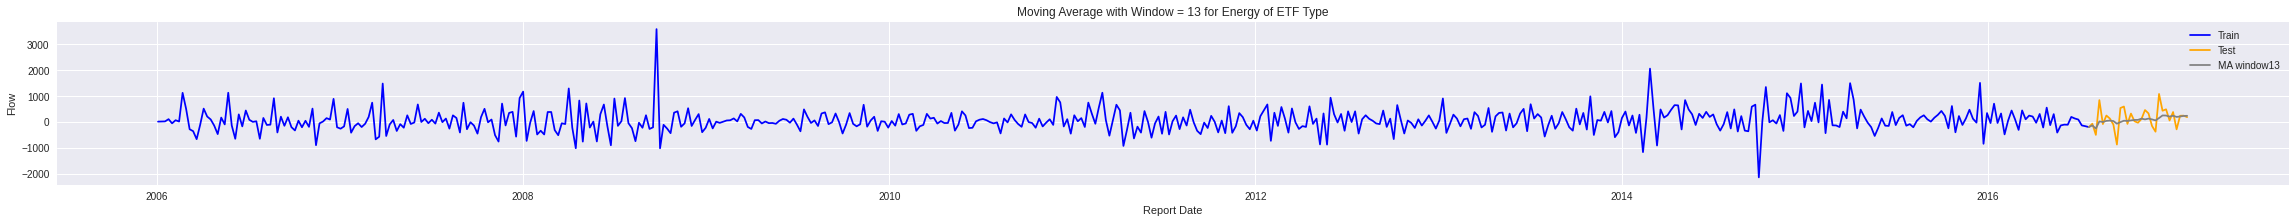

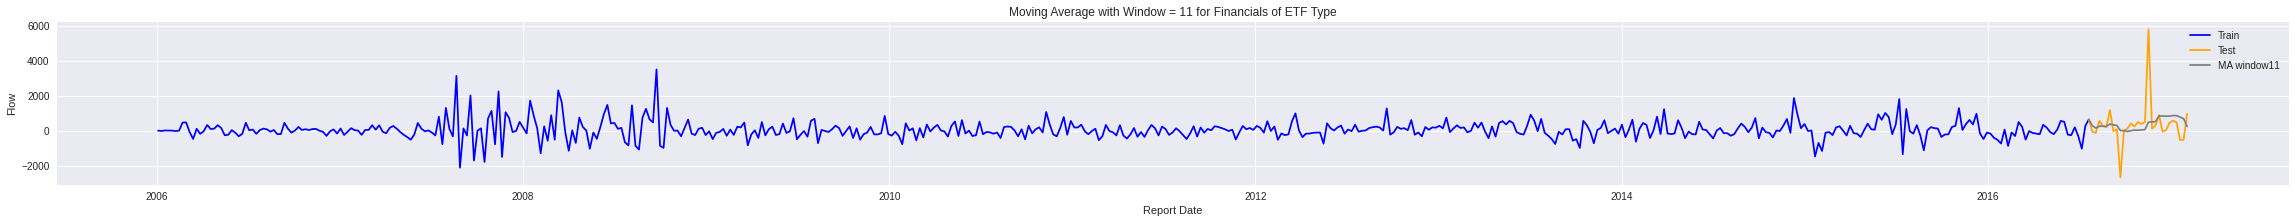

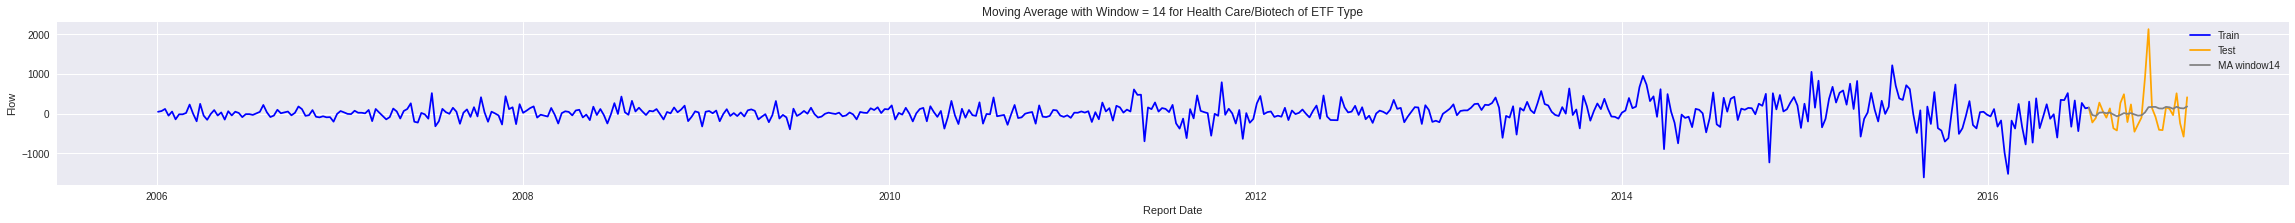

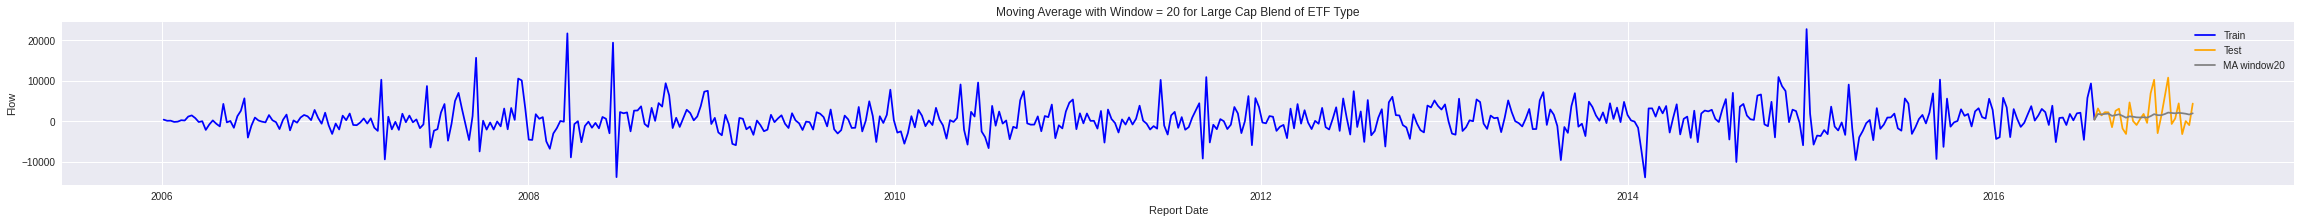

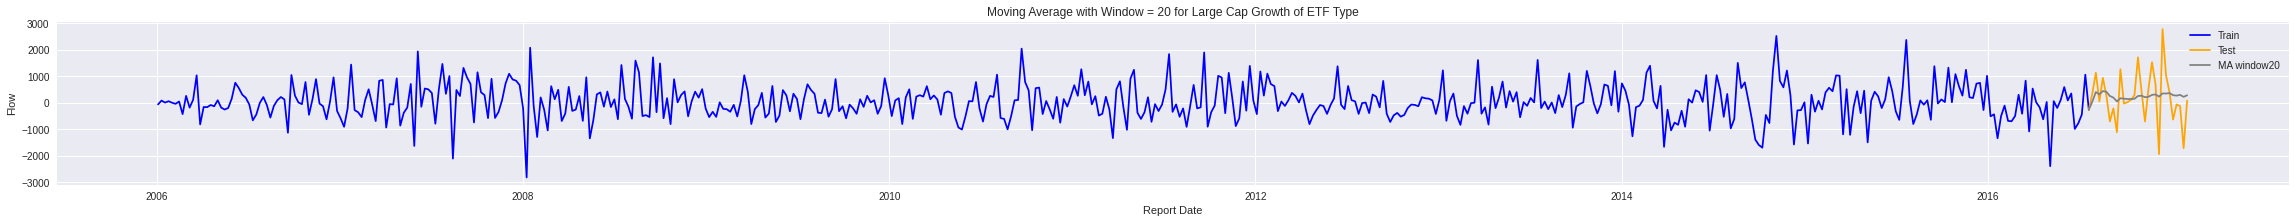

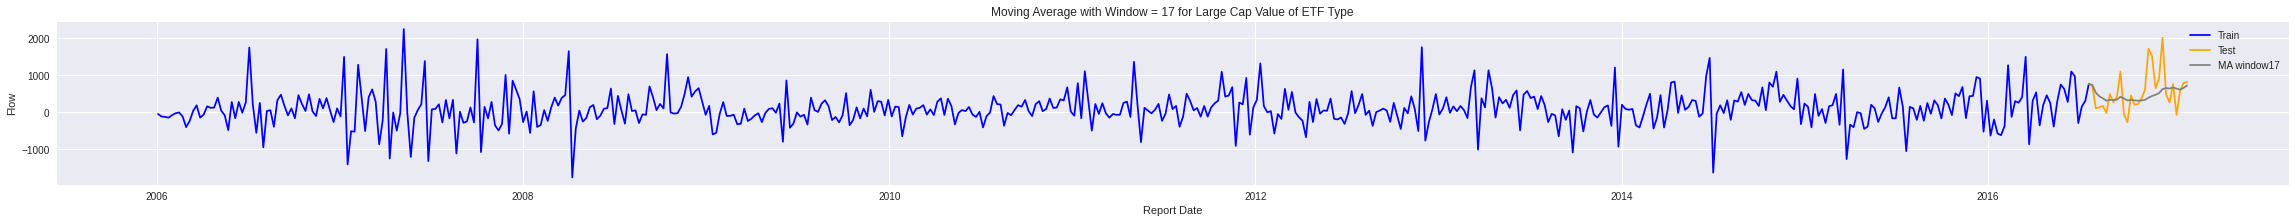

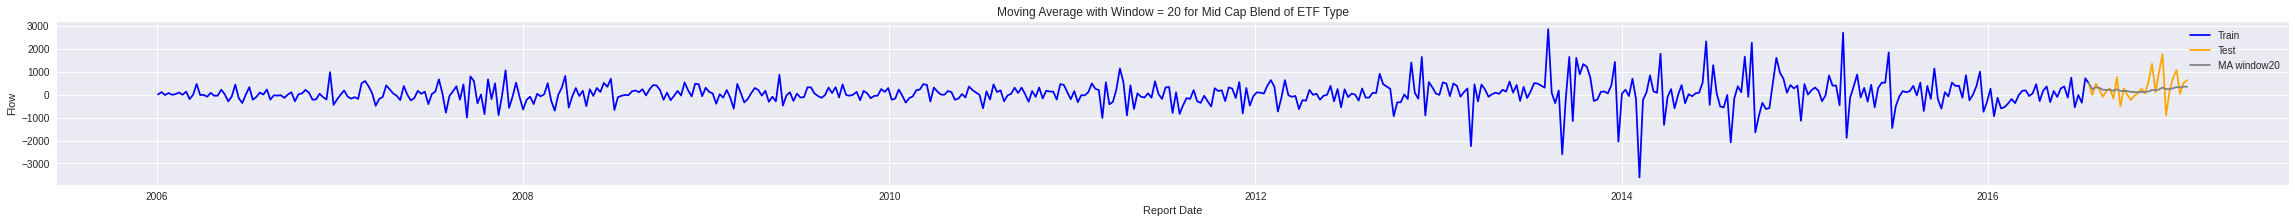

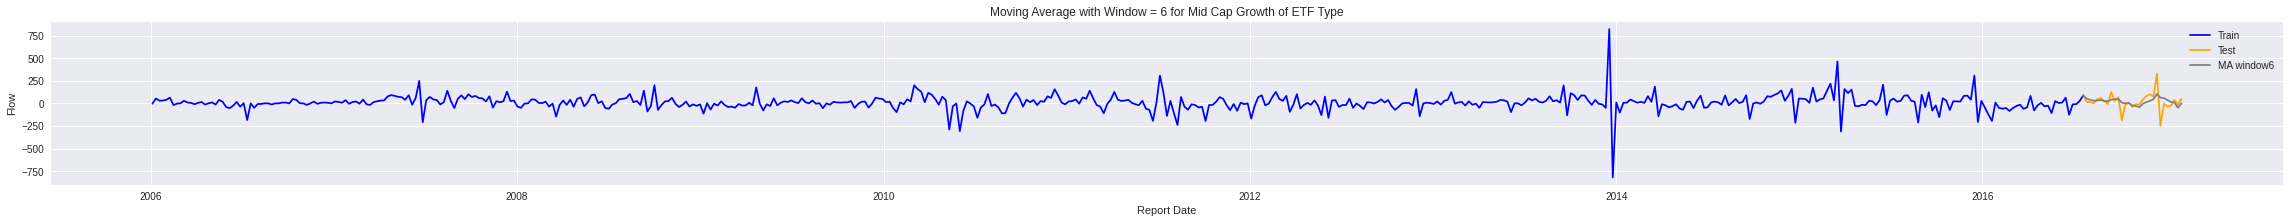

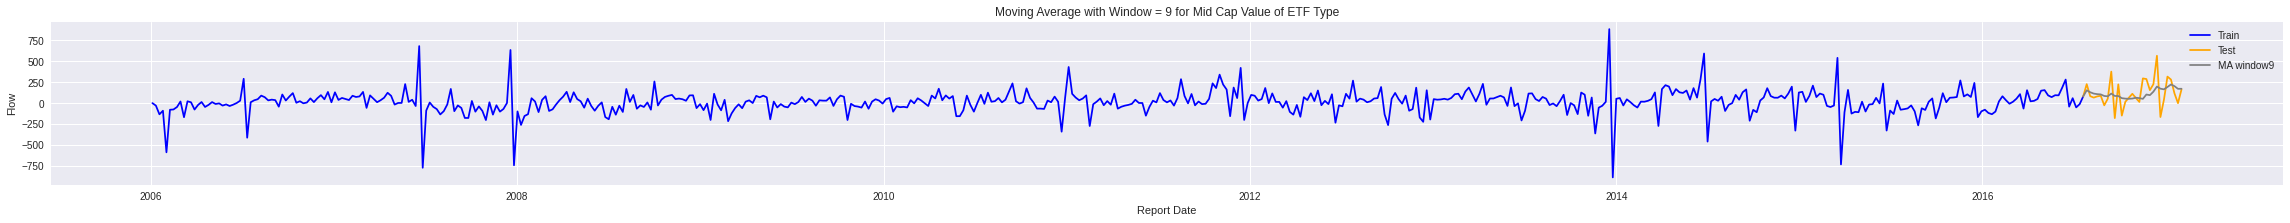

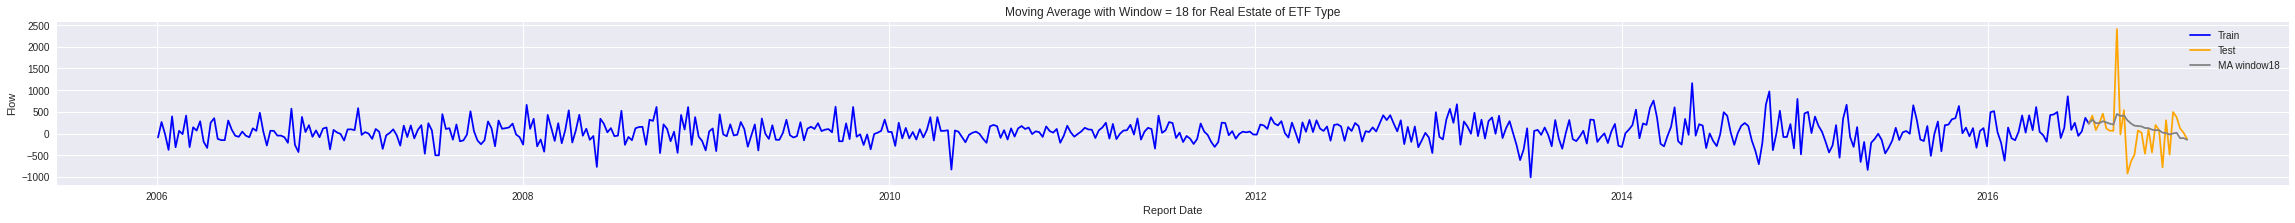

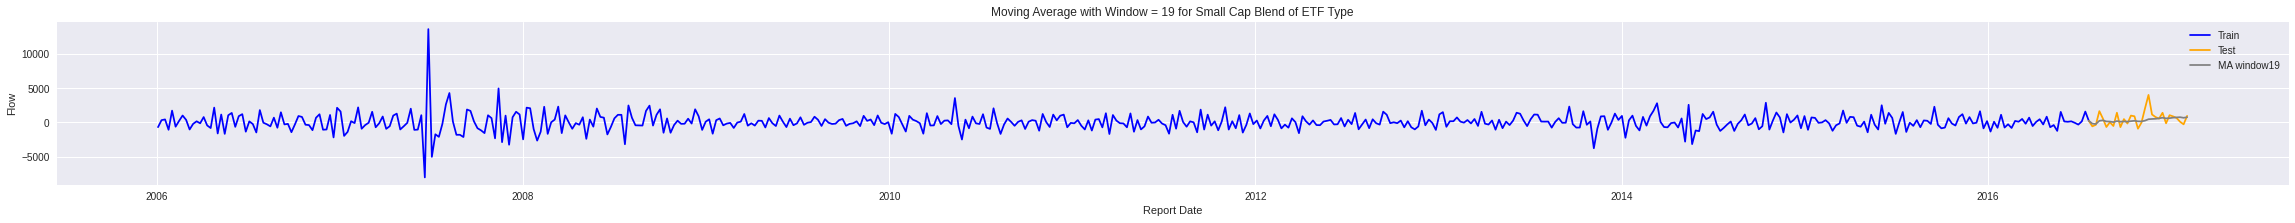

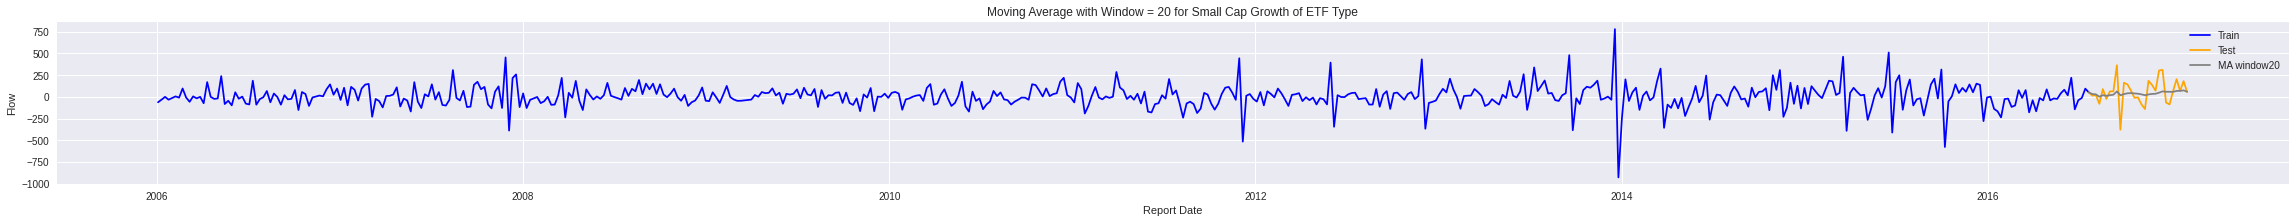

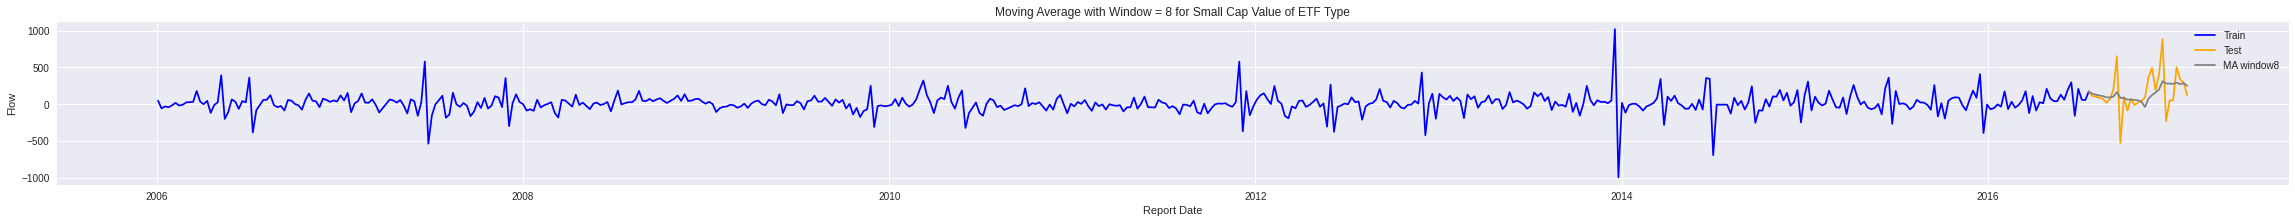

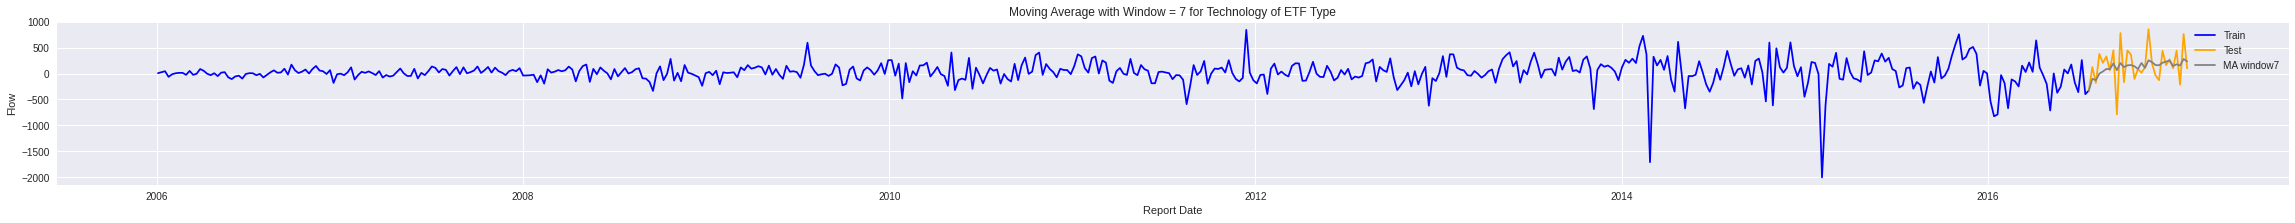

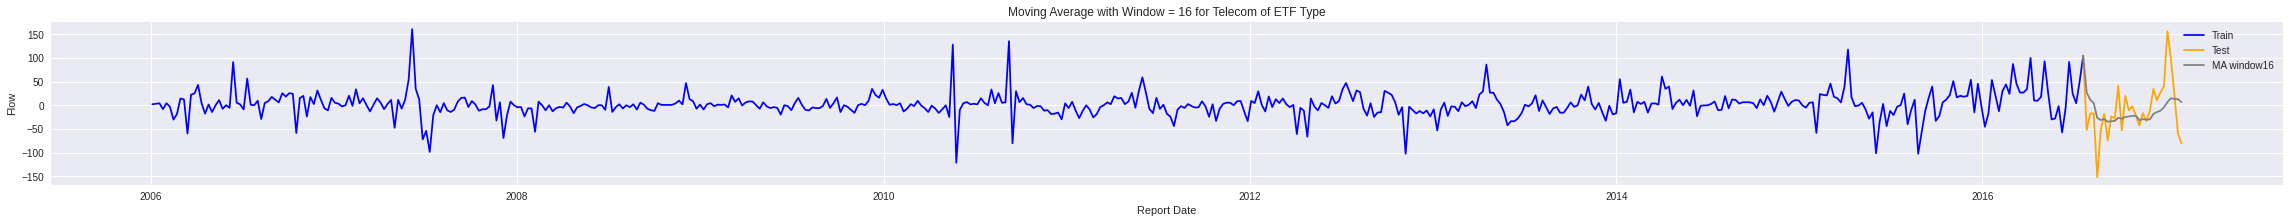

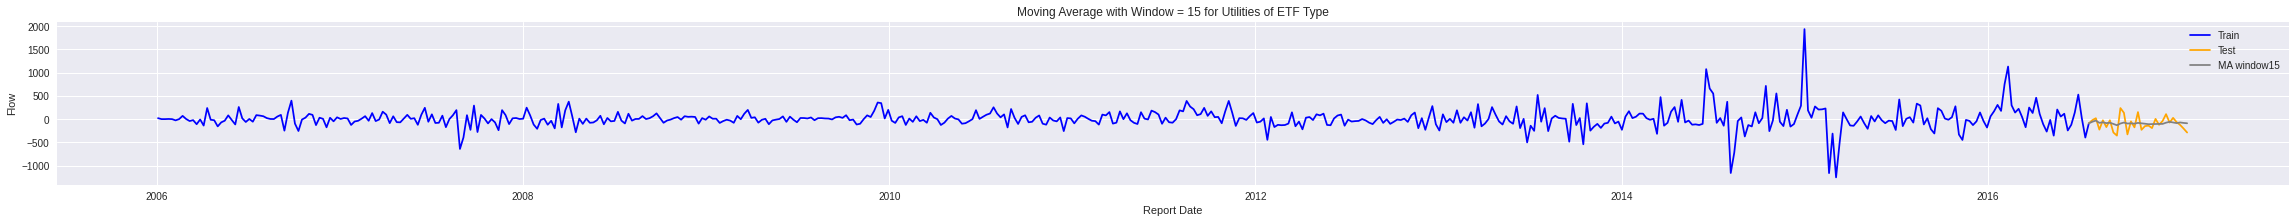

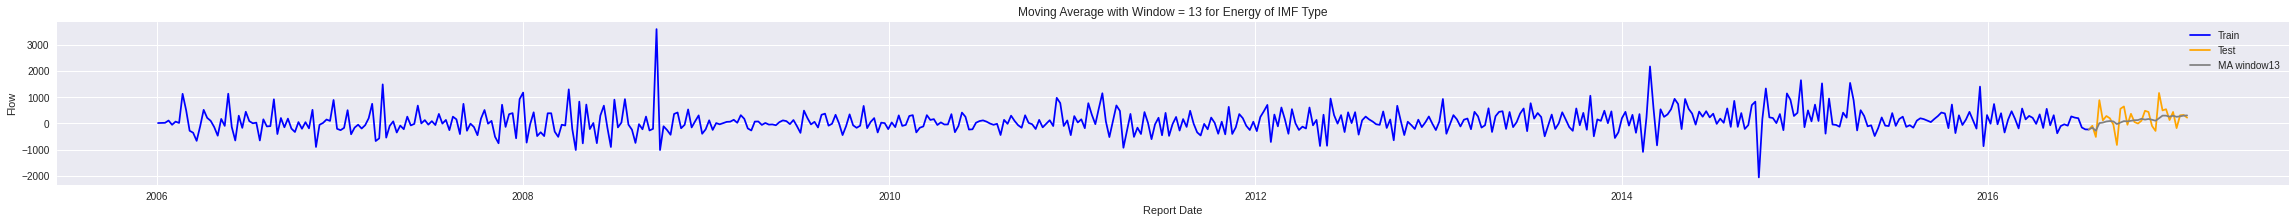

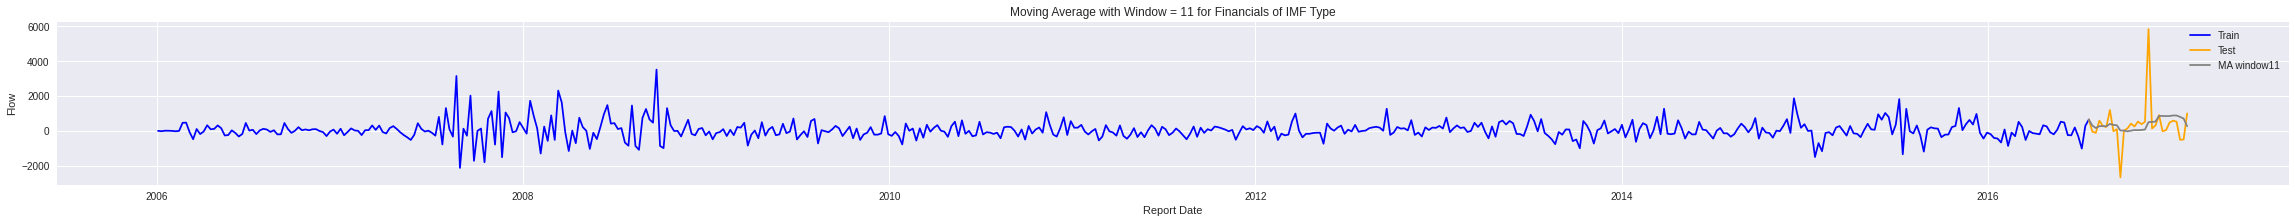

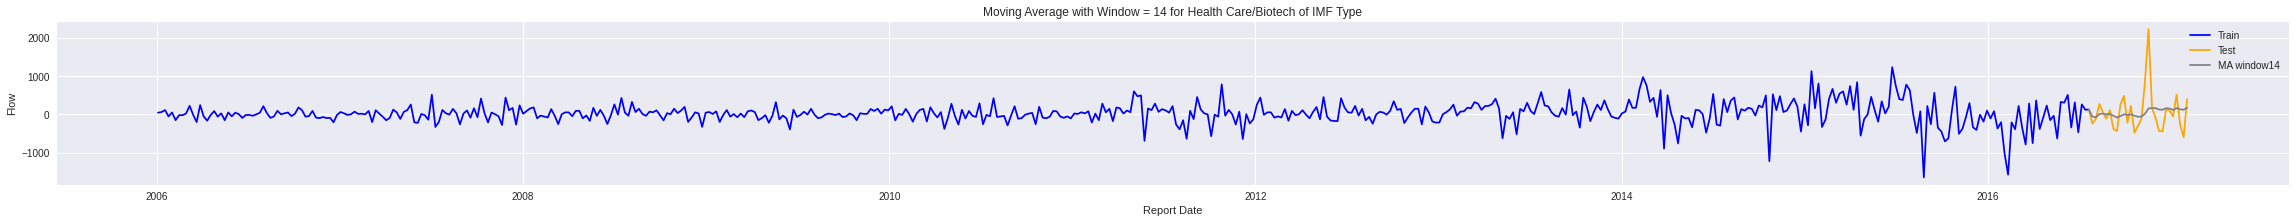

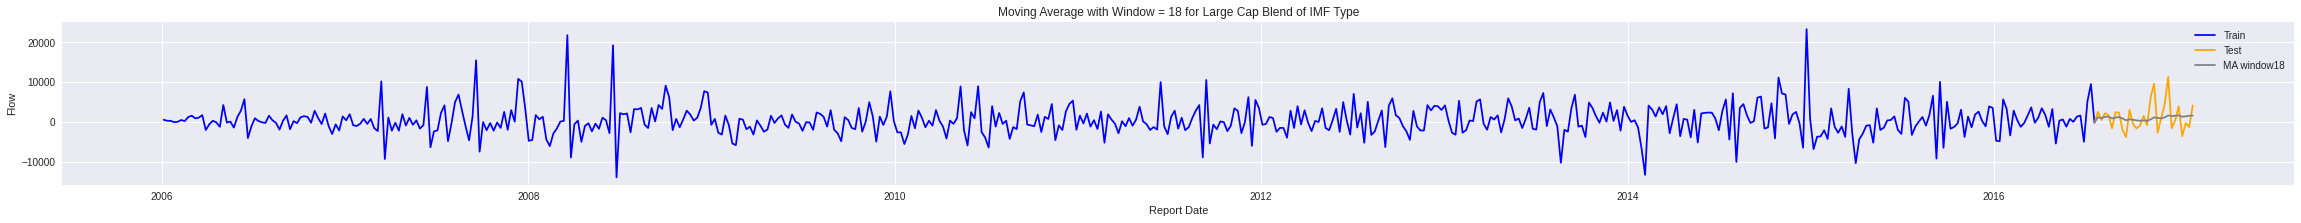

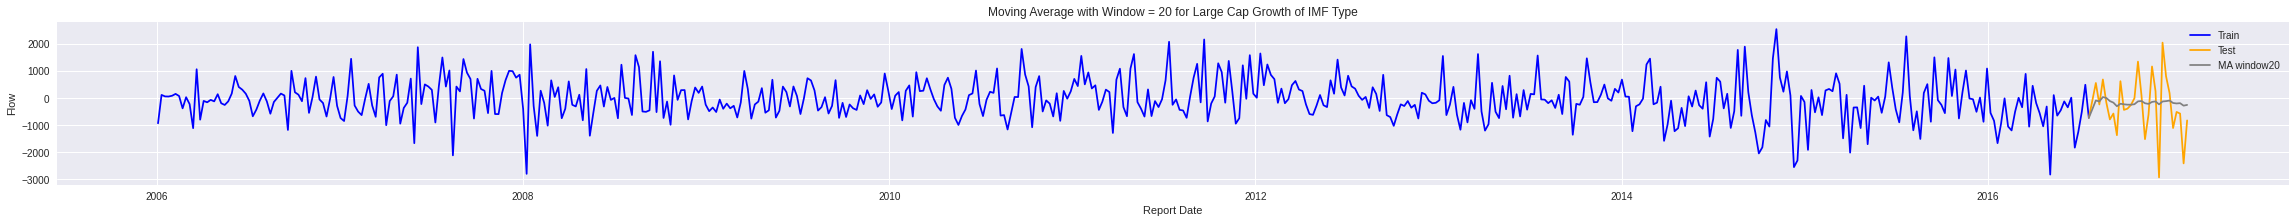

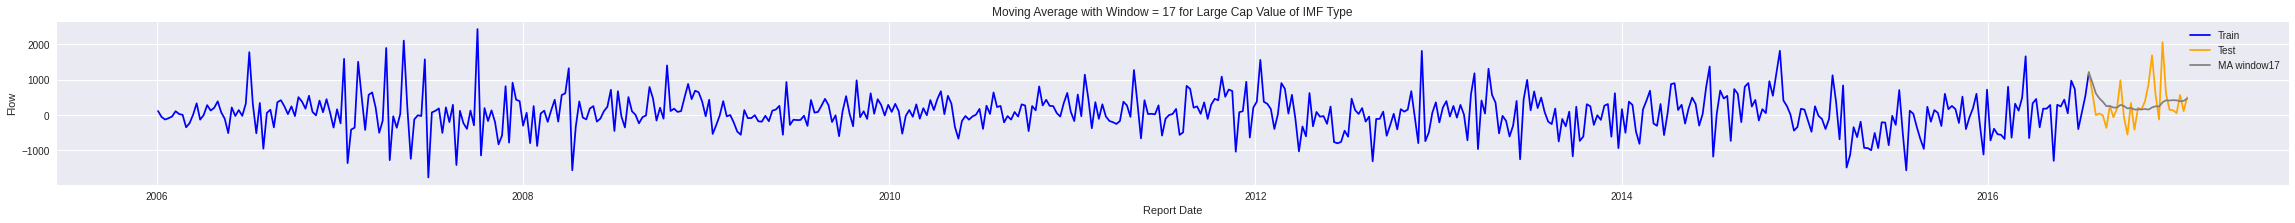

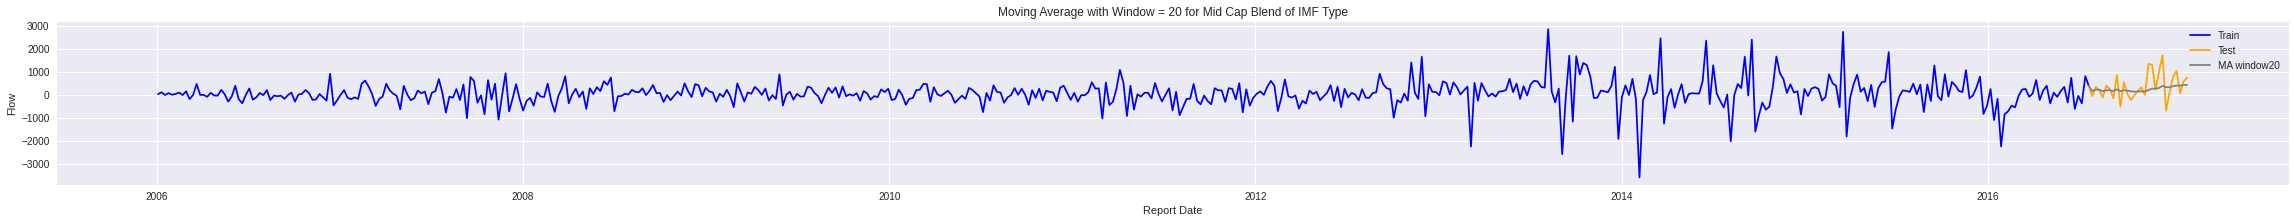

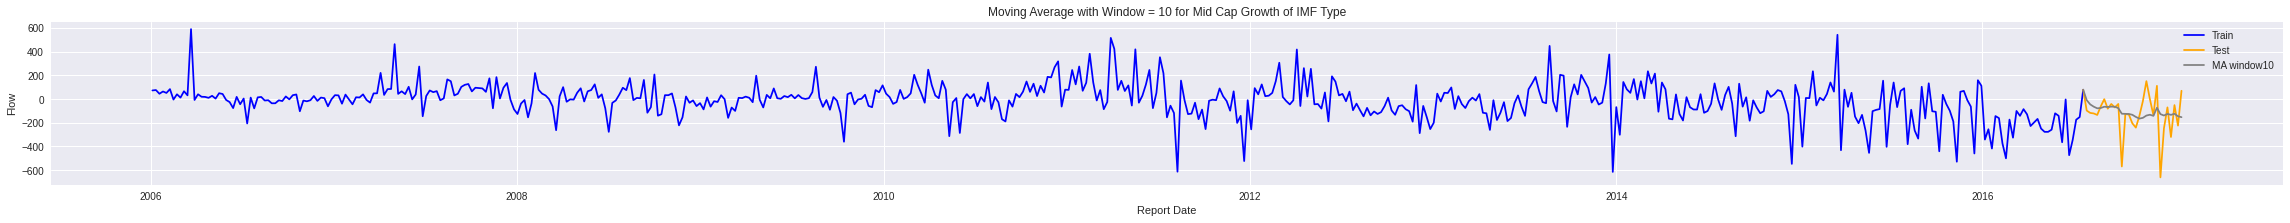

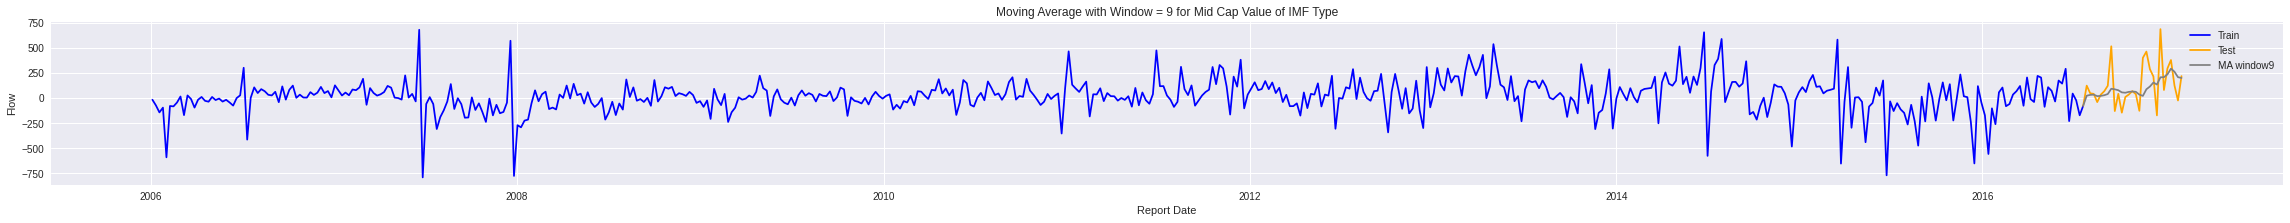

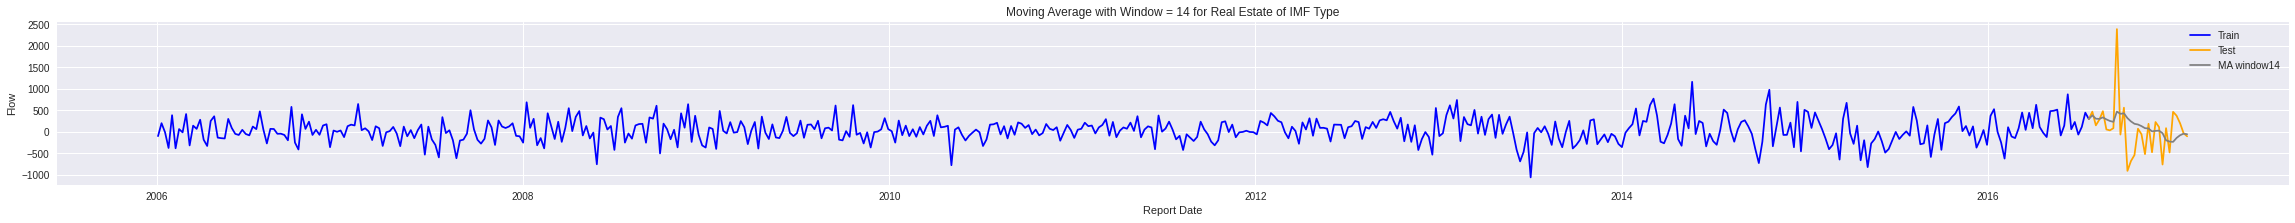

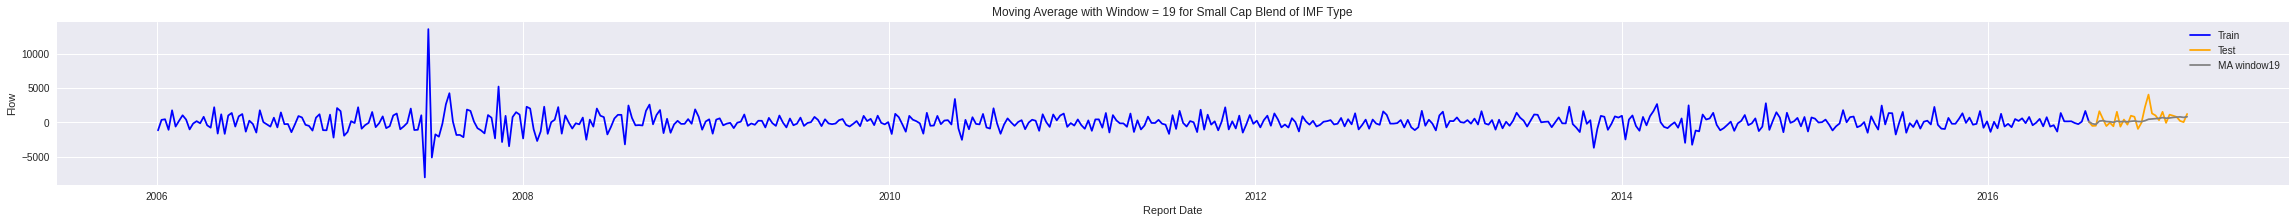

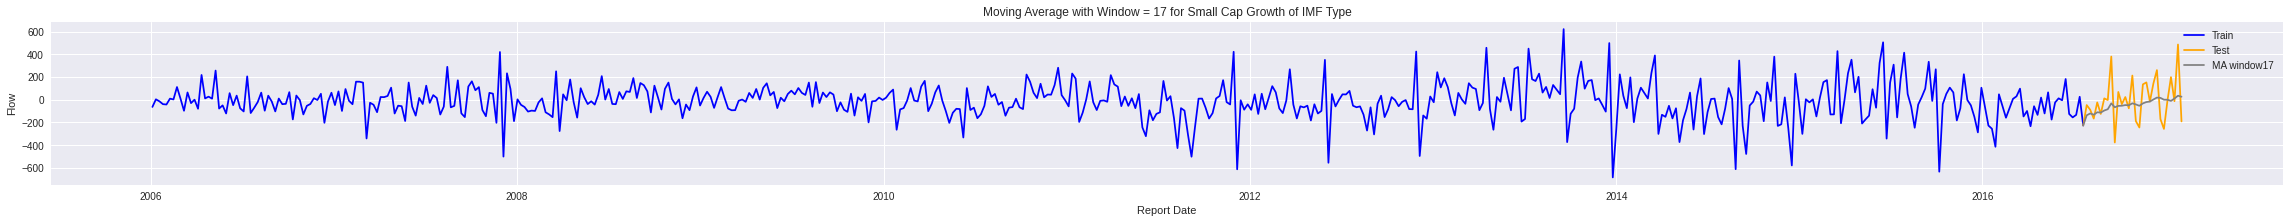

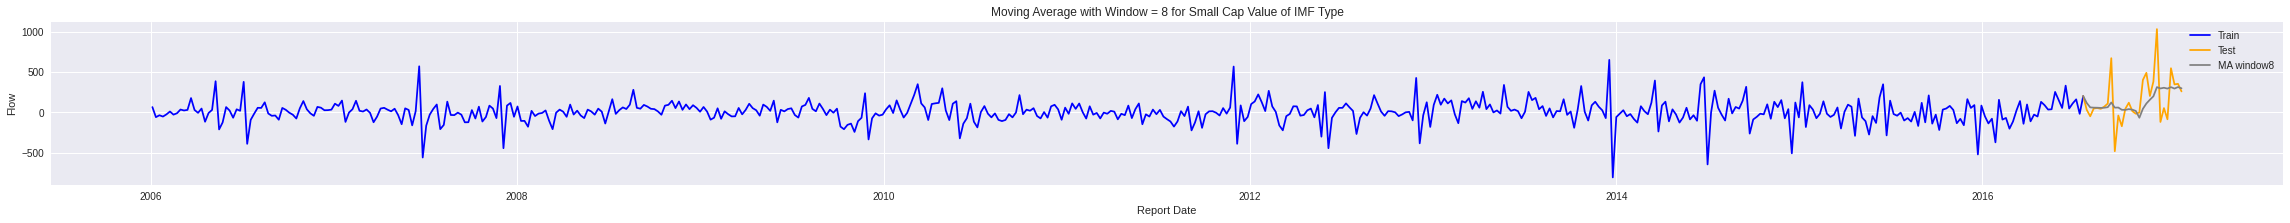

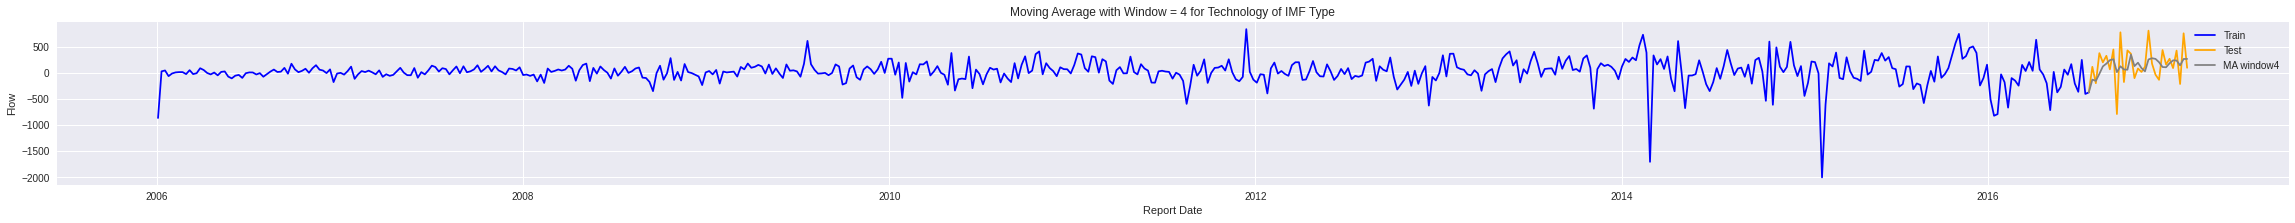

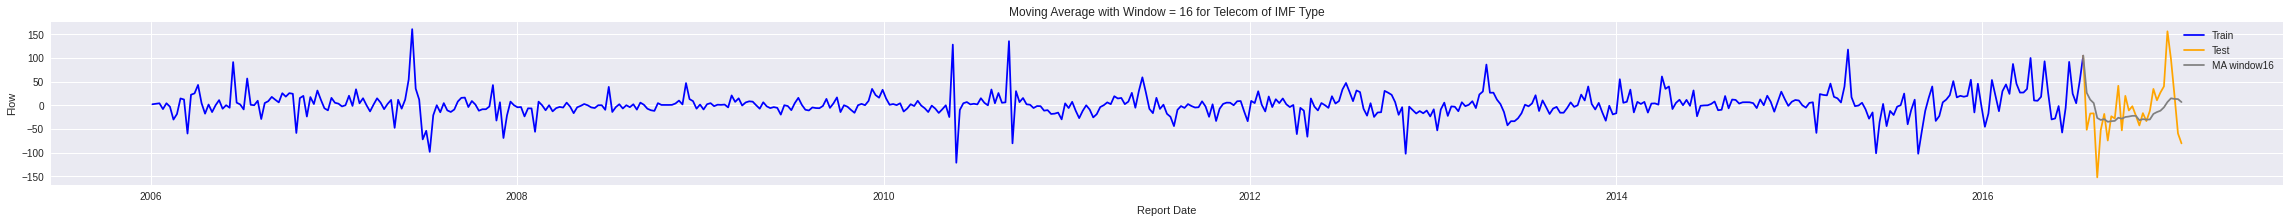

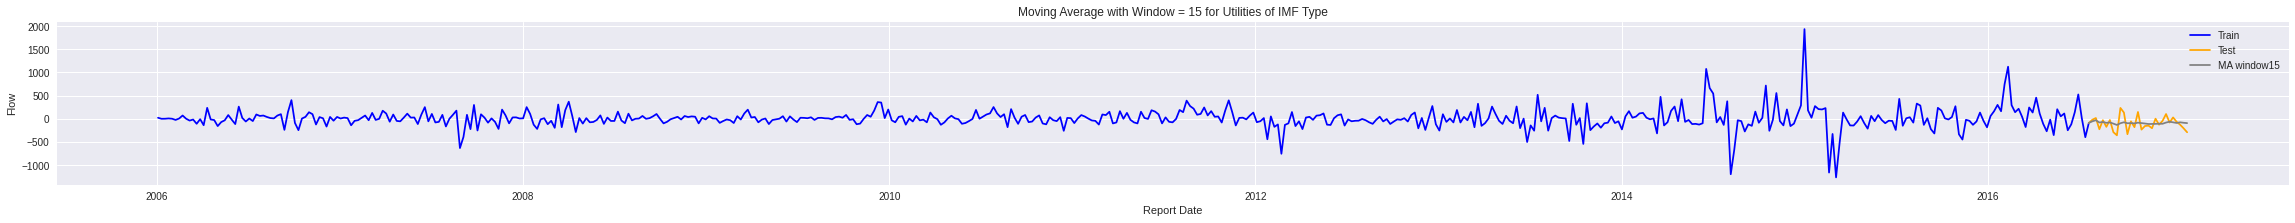

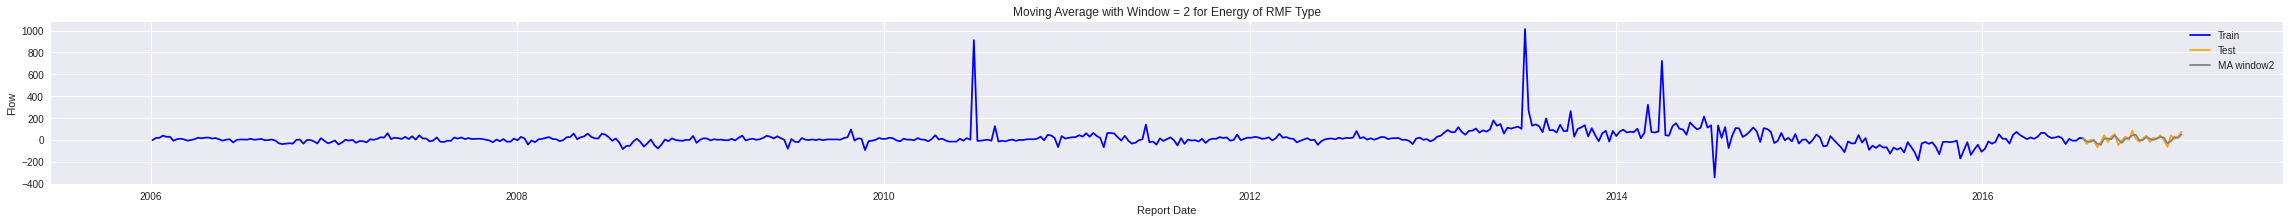

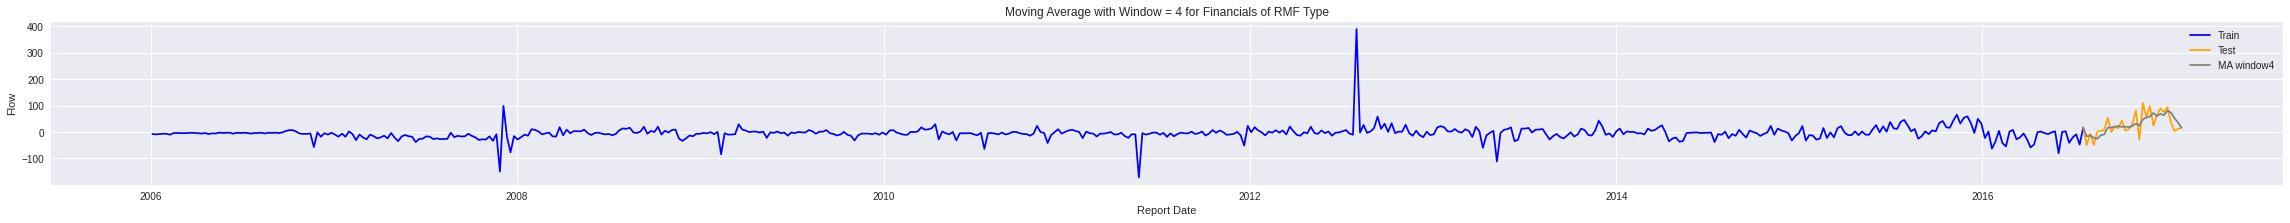

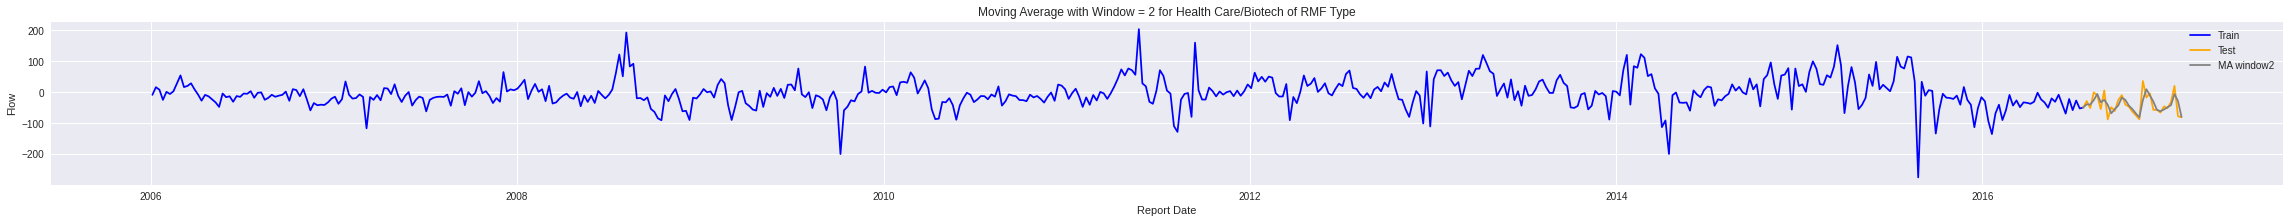

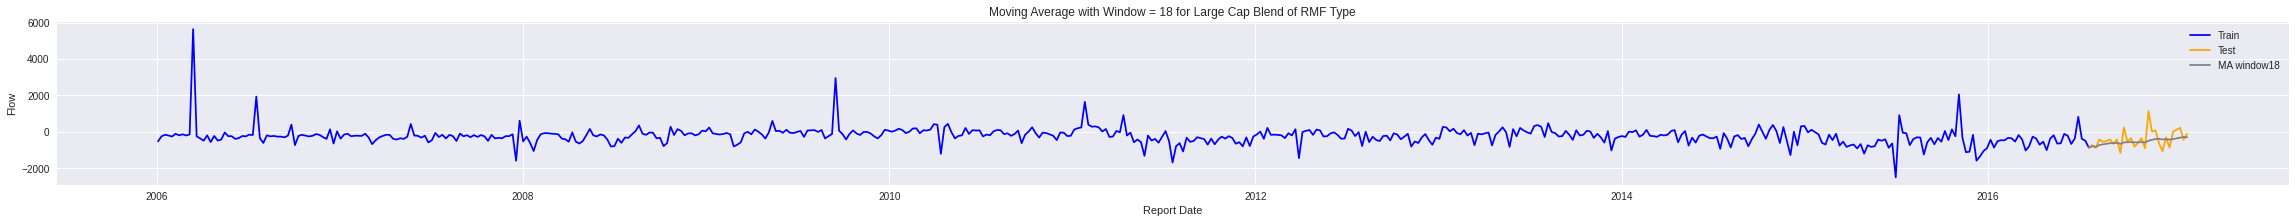

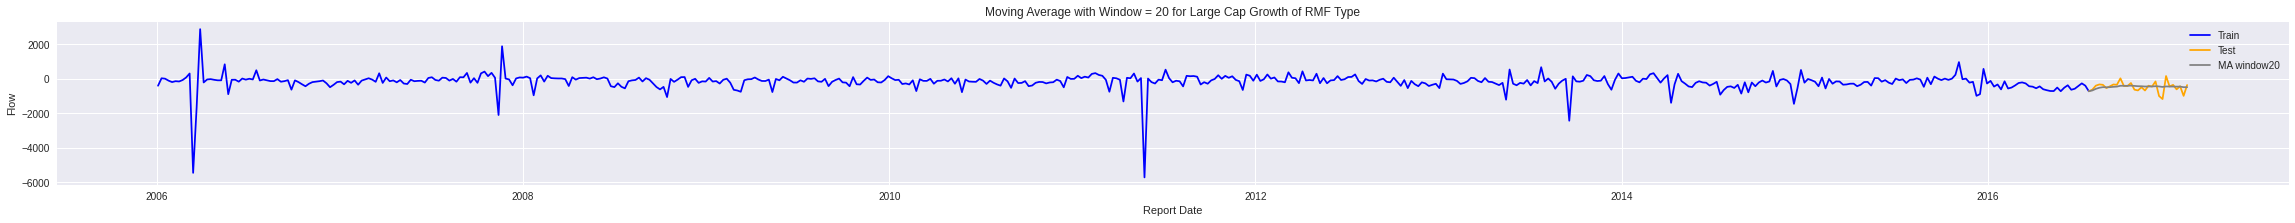

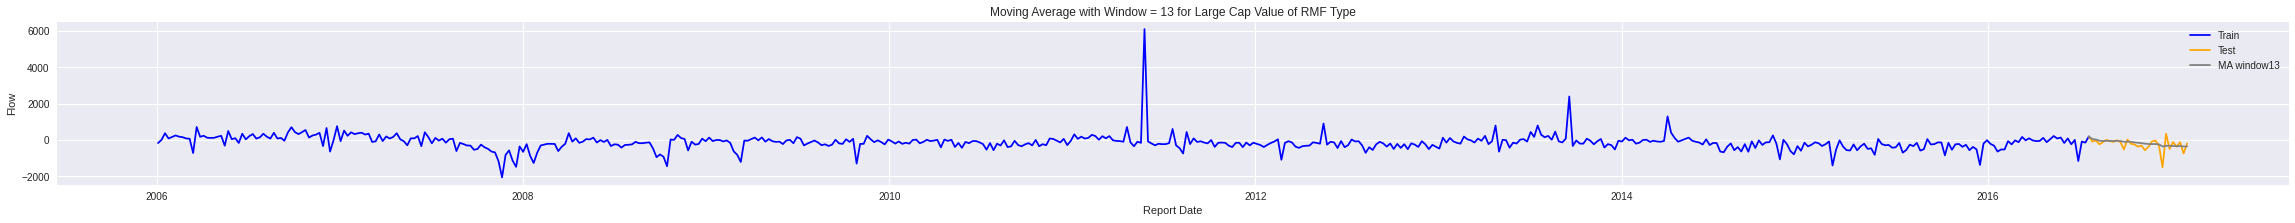

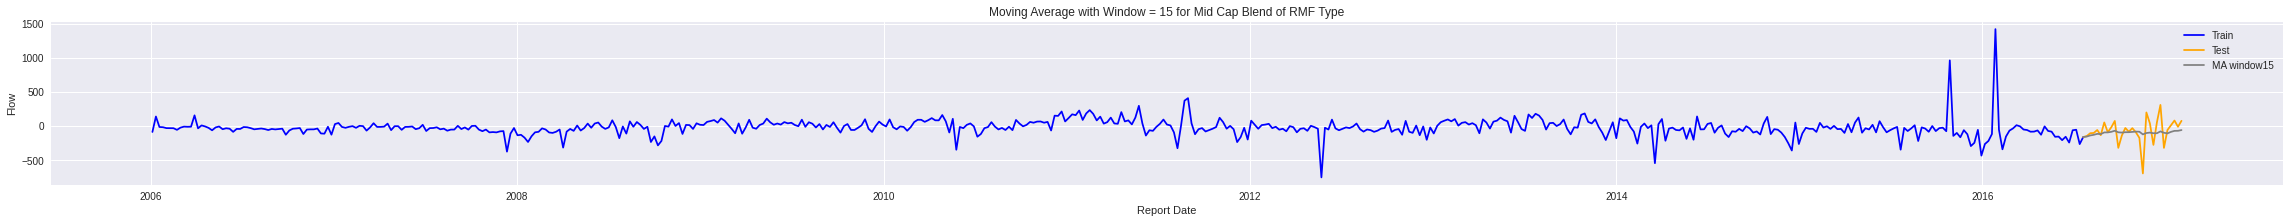

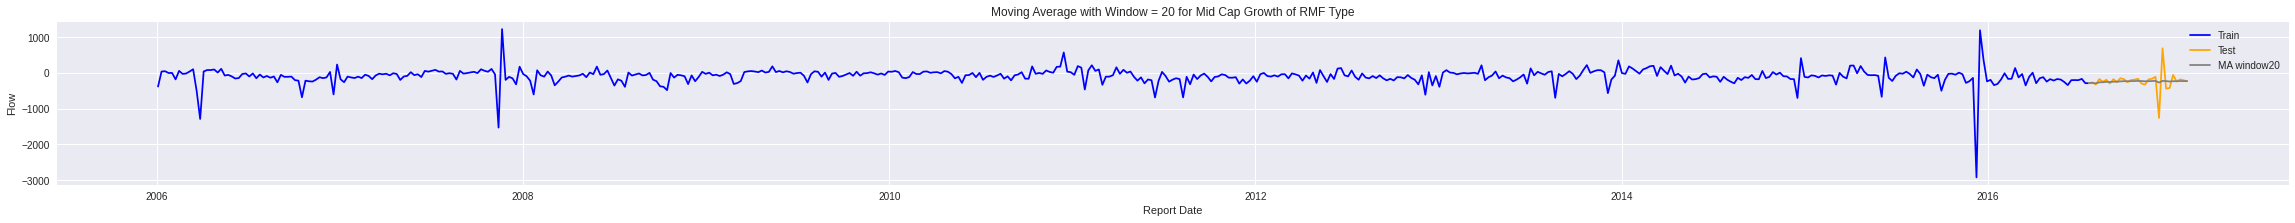

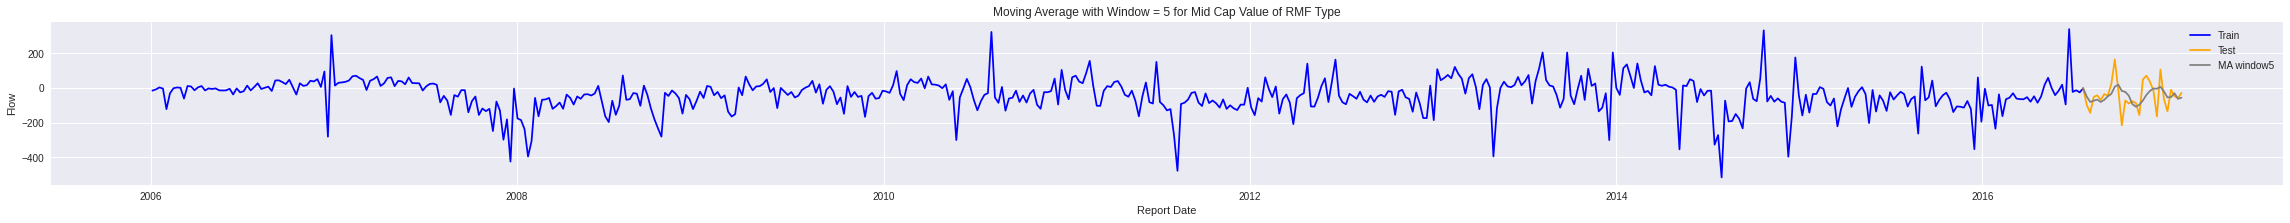

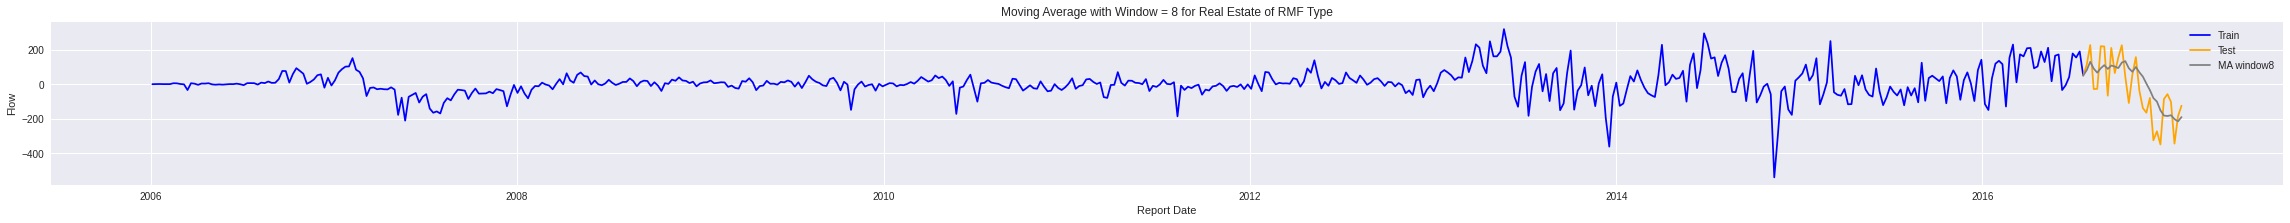

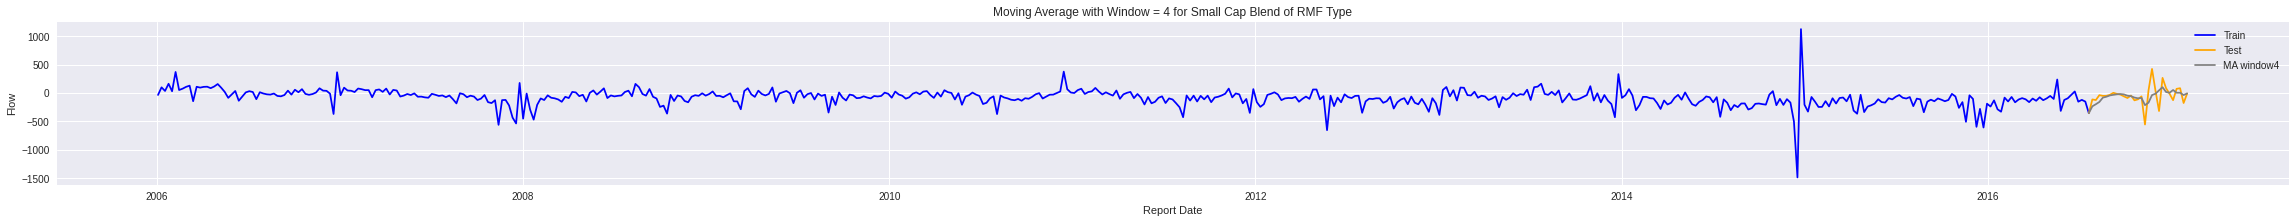

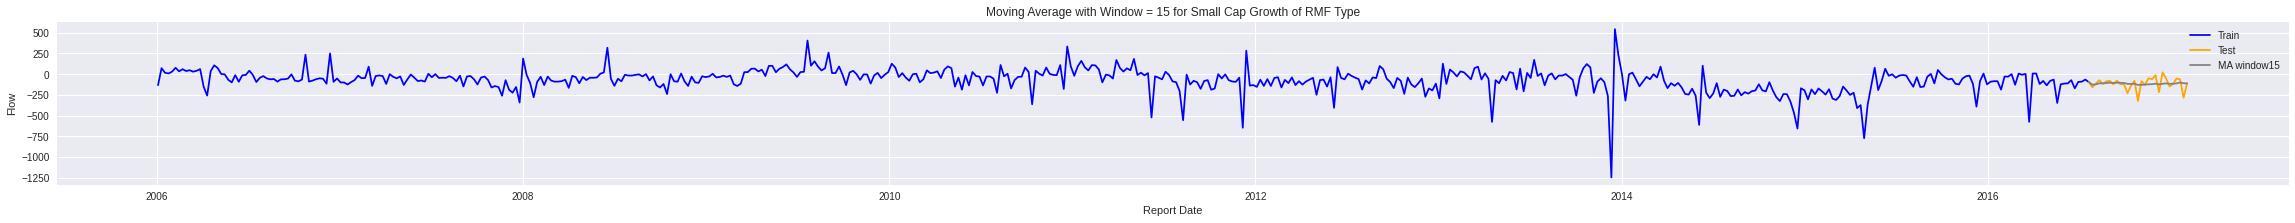

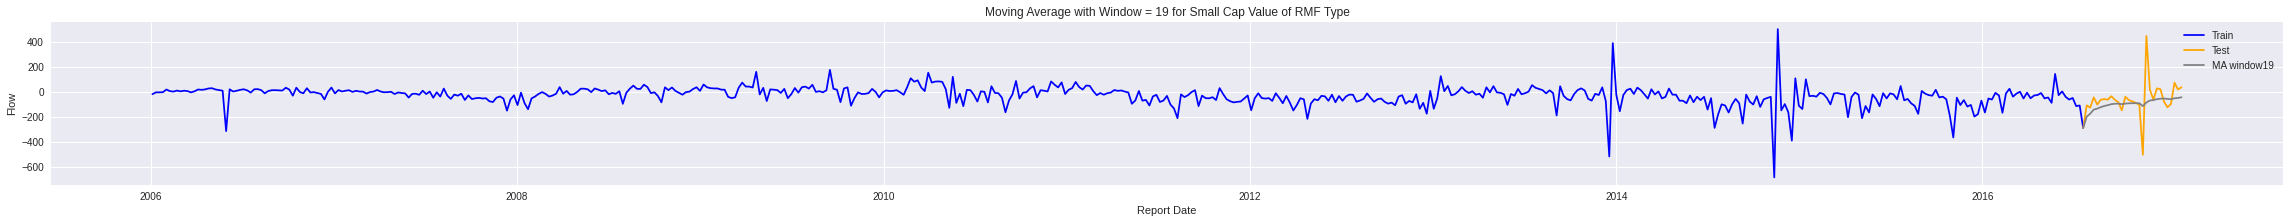

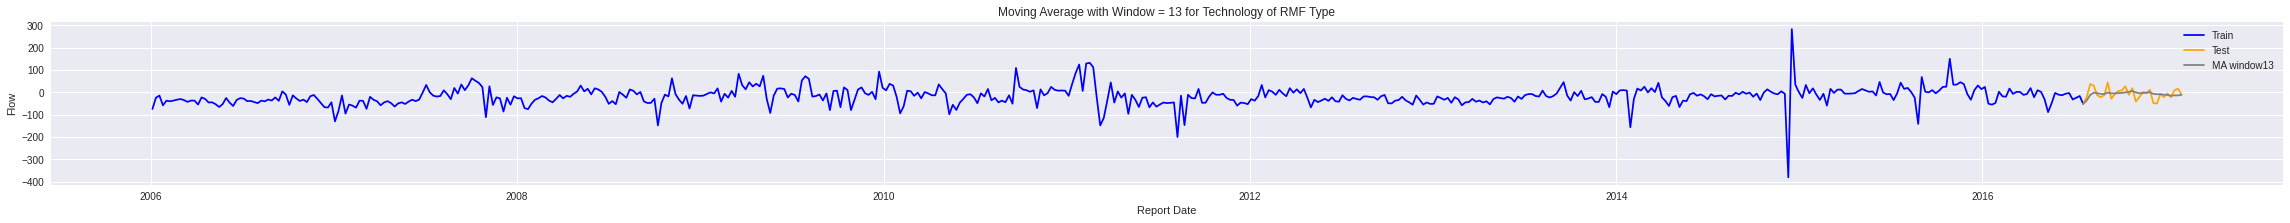

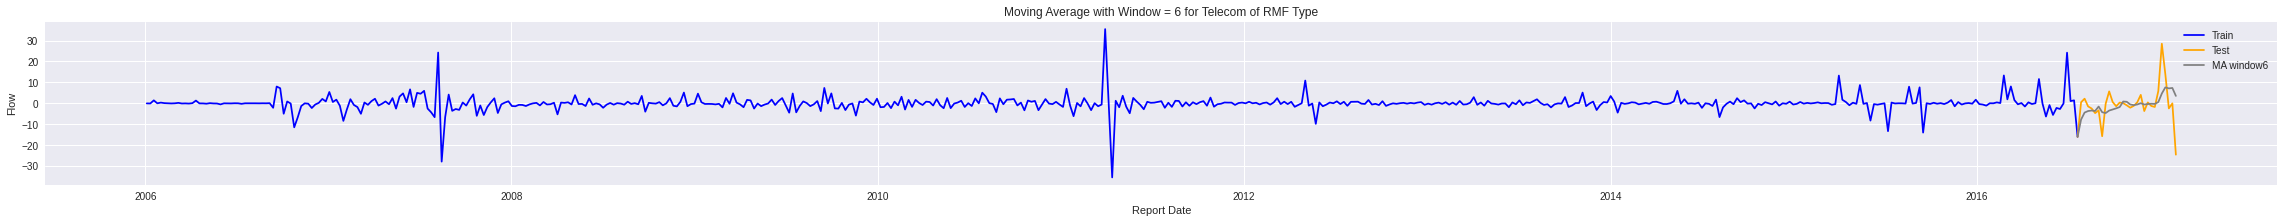

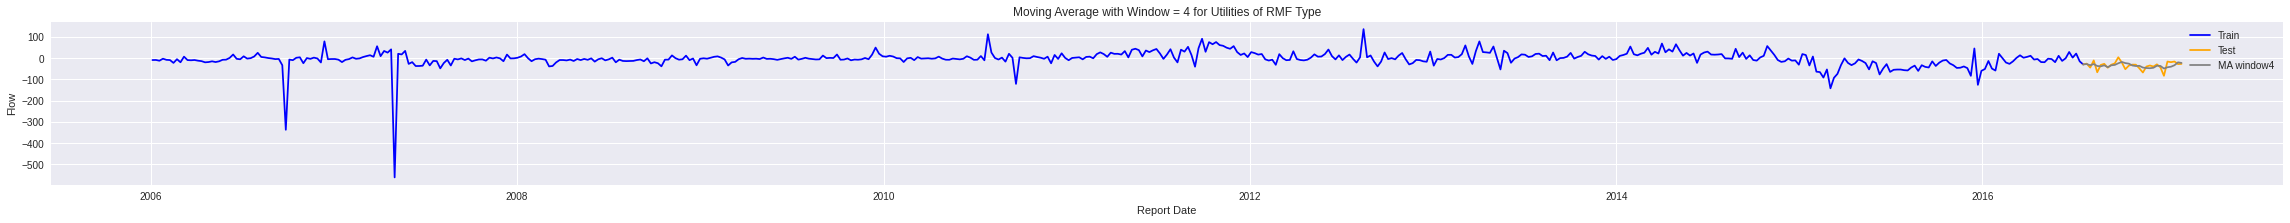

In [ ]:
# iterating for flow & MA window saved in above dataframe
for i in range(df_ma_final.shape[0]):
  # subset 
  sub = data.loc[(data.Type == df_ma_final.iloc[i].Type) & (data.Industry == df_ma_final.iloc[i].Industry)][['ReportDate', 'Flow']]
  # reorder sequence
  sub.sort_values('ReportDate', ascending  = True, inplace=True)
  # train & test split
  train = sub.iloc[:551]
  test = sub.iloc[550:]
  # predict with best ma window
  pred_ma = test.Flow.rolling(df_ma_final.iloc[i]['MA window'], min_periods = 1).mean()
  # plot
  plt.figure(figsize=(40,3))
  plt.plot(train.ReportDate, train.Flow, c = 'b', label = 'Train')
  plt.plot(test.ReportDate, test.Flow, c = 'orange', label = 'Test')
  ma_window = "MA window" + str(df_ma_final.iloc[i]['MA window'])
  plt.plot(test.ReportDate, pred_ma, c = 'grey', label = ma_window)
  plt.title('Moving Average with Window = {} for {} of {} Type'.format(df_ma_final.iloc[i]['MA window'], df_ma_final.iloc[i]['Industry'], df_ma_final.iloc[i]['Type']))
  plt.xlabel('Report Date')
  plt.ylabel('Flow')
  plt.legend()
  plt.show()

In [ ]:
# if needed to store output
# df_ma_final.to_csv('moving_avg_output.csv')

-------

## Simple Exponential Smoothing

In [ ]:
df_ses = pd.DataFrame()

In [ ]:
# iterating for 3 types
for t in data.Type.unique():
  # iterating for 16 industries 
  for i in industries:
    # ma window
    sub = data.loc[(data.Type == t) & (data.Industry == i)][['ReportDate', 'Flow']]
    for alpha in np.arange(0.1, 1.1, 0.1):
      # calculating mse
      mse = mean_squared_error(sub.Flow[550:],ExponentialSmoothing(sub.Flow).fit(smoothing_level = alpha).predict(550,))

      df_ses = df_ses.append({'Type': t,
                            'Industry': i,
                            'SES alpha': alpha,
                            'SES mse': mse}, ignore_index = True
                           )

In [ ]:
df_ses

Type   Industry  SES alpha        SES mse
0    ETF     Energy        0.1  181055.909260
1    ETF     Energy        0.2  196442.184190
2    ETF     Energy        0.3  211393.780202
3    ETF     Energy        0.4  225551.850059
4    ETF     Energy        0.5  238887.927022
..   ...        ...        ...            ...
475  RMF  Utilities        0.6      78.594105
476  RMF  Utilities        0.7      82.907386
477  RMF  Utilities        0.8      88.519743
478  RMF  Utilities        0.9      95.753710
479  RMF  Utilities        1.0     105.056896

[480 rows x 4 columns]

In [ ]:
# groupby mse values by Type and Industries, and sort values by mse
df_ses = df_ses.groupby(['Type','Industry']).apply(lambda x: x.sort_values(["SES mse"], ascending = True)).reset_index(drop=True)

In [ ]:
# store best result
df_ses_final = pd.DataFrame()

for i in range(0, 480, 10):
  df_ses_final = df_ses_final.append(df_ses.iloc[i])

In [ ]:
df_ses_final.reset_index(inplace=True)
df_ses_final = df_ses_final.iloc[:, 1:]
df_ses_final

Type             Industry  SES alpha       SES mse
0   ETF               Energy        0.1  1.810559e+05
1   ETF           Financials        0.1  5.545442e+04
2   ETF  Health Care/Biotech        0.1  1.063216e+04
3   ETF      Large Cap Blend        0.1  3.374319e+06
4   ETF     Large Cap Growth        0.1  1.492183e+05
5   ETF      Large Cap Value        0.1  1.608566e+05
6   ETF        Mid Cap Blend        0.1  3.649100e+04
7   ETF       Mid Cap Growth        0.2  1.829638e+03
8   ETF        Mid Cap Value        0.1  2.339144e+04
9   ETF          Real Estate        0.1  5.241447e+04
10  ETF      Small Cap Blend        0.1  1.144424e+06
11  ETF     Small Cap Growth        0.1  7.163444e+03
12  ETF      Small Cap Value        0.1  2.144024e+04
13  ETF           Technology        0.3  1.968853e+03
14  ETF              Telecom        0.1  7.368029e+02
15  ETF            Utilities        0.1  8.744426e+03
16  IMF               Energy        0.1  1.810334e+05
17  IMF           Financials        0.1  5.545295e+04
18  IMF  Health Care/Biotech        0.1  1.069554e+04
19  IMF      Large Cap Blend        0.1  3.441461e+06
20  IMF     Large Cap Growth        0.1  2.163060e+05
21  IMF      Large Cap Value        0.1  1.631840e+05
22  IMF        Mid Cap Blend        0.1  3.417704e+04
23  IMF       Mid Cap Growth        0.1  1.430911e+04
24  IMF        Mid Cap Value        0.1  2.381932e+04
25  IMF          Real Estate        0.1  5.334851e+04
26  IMF      Small Cap Blend        0.1  1.191332e+06
27  IMF     Small Cap Growth        0.1  9.798641e+03
28  IMF      Small Cap Value        0.1  2.232227e+04
29  IMF           Technology        0.1  2.830879e+04
30  IMF              Telecom        0.1  7.368029e+02
31  IMF            Utilities        0.1  8.790759e+03
32  RMF               Energy        0.6  1.516567e+02
33  RMF           Financials        0.4  3.168411e+00
34  RMF  Health Care/Biotech        0.6  3.171519e+02
35  RMF      Large Cap Blend        0.1  1.443019e+06
36  RMF     Large Cap Growth        0.1  1.574836e+06
37  RMF      Large Cap Value        0.1  7.028869e+04
38  RMF        Mid Cap Blend        0.1  2.776529e+03
39  RMF       Mid Cap Growth        0.1  7.665091e+04
40  RMF        Mid Cap Value        0.2  8.191287e+02
41  RMF          Real Estate        0.3  6.632460e+01
42  RMF      Small Cap Blend        0.2  1.015928e+04
43  RMF     Small Cap Growth        0.1  6.947379e+03
44  RMF      Small Cap Value        0.1  3.937471e+03
45  RMF           Technology        0.1  2.055814e+02
46  RMF              Telecom        0.1  1.530775e-01
47  RMF            Utilities        0.3  6.982098e+01

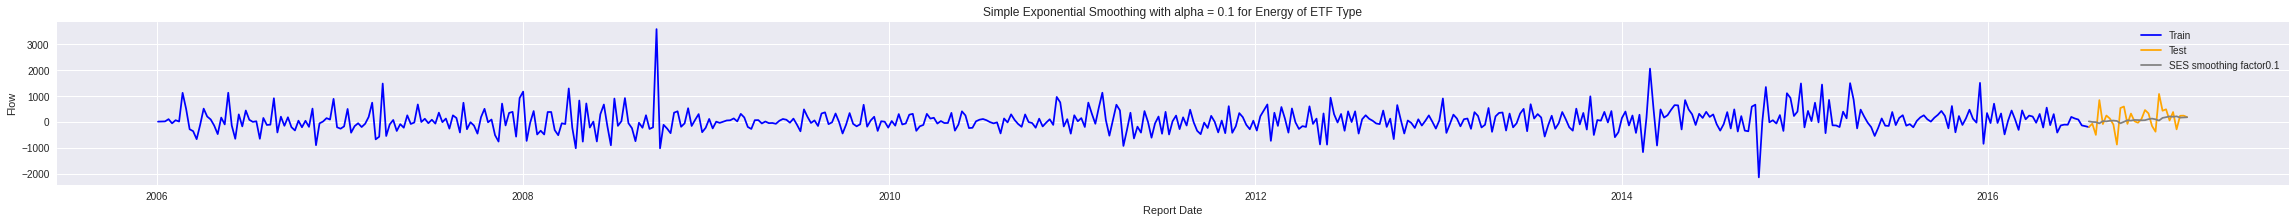

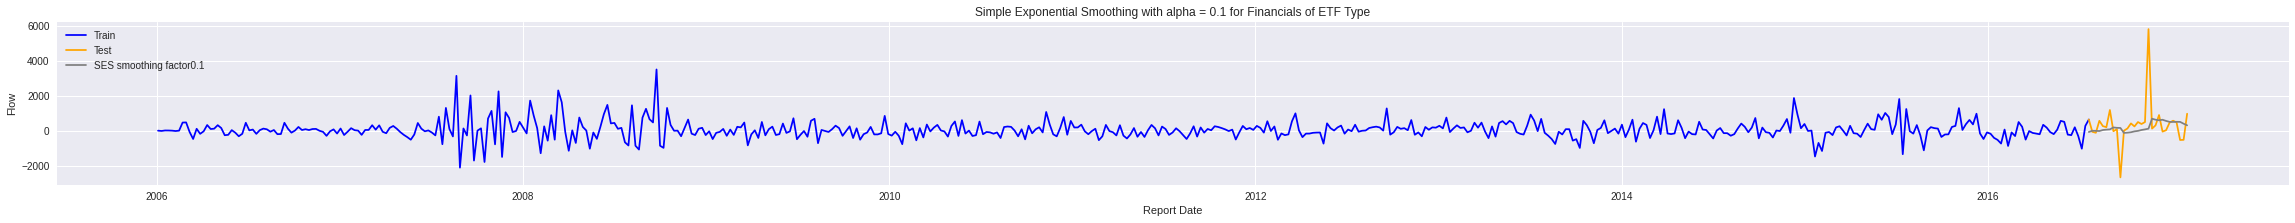

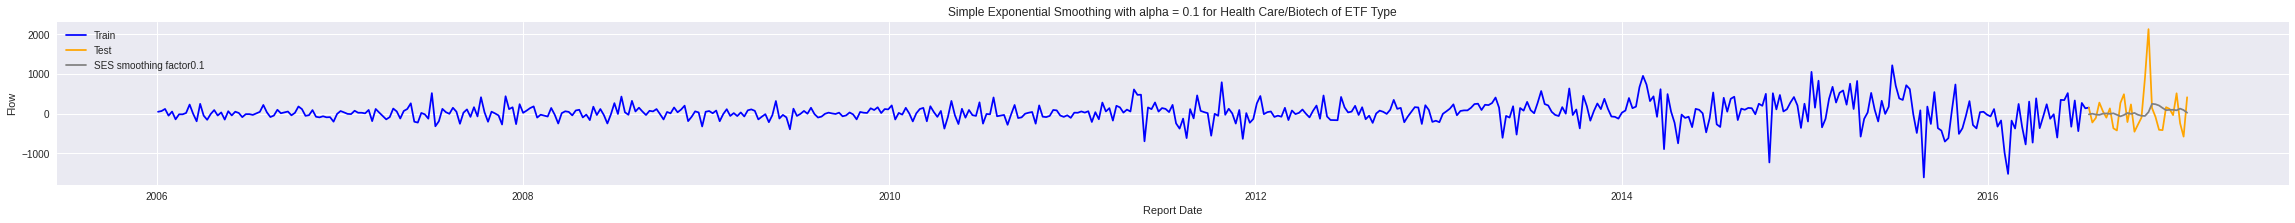

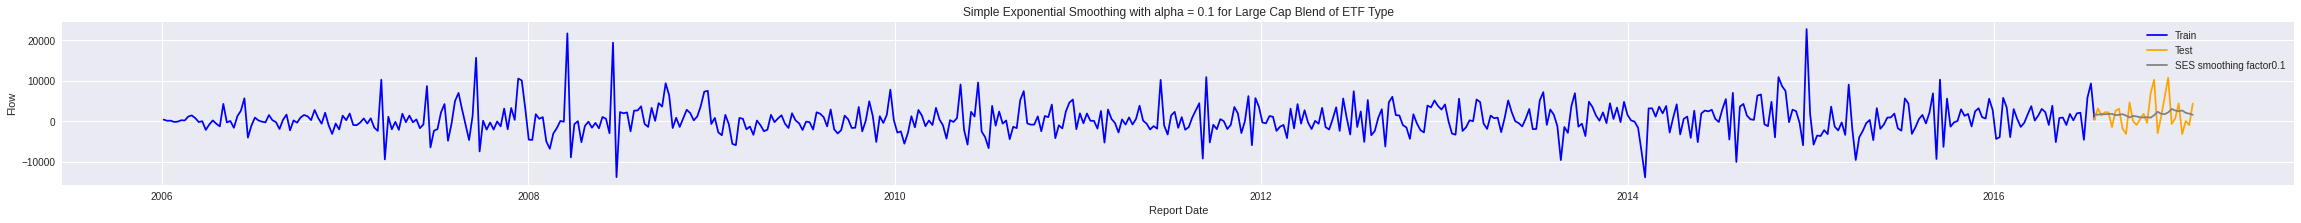

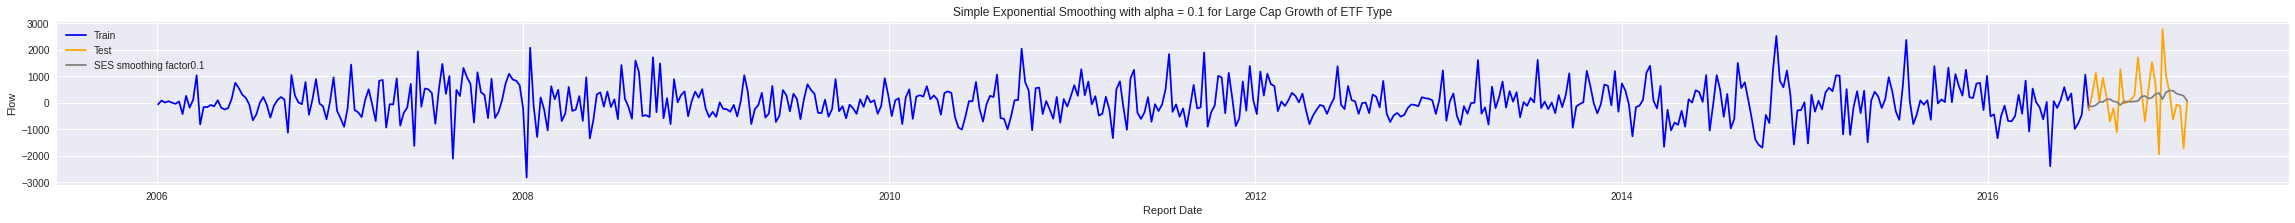

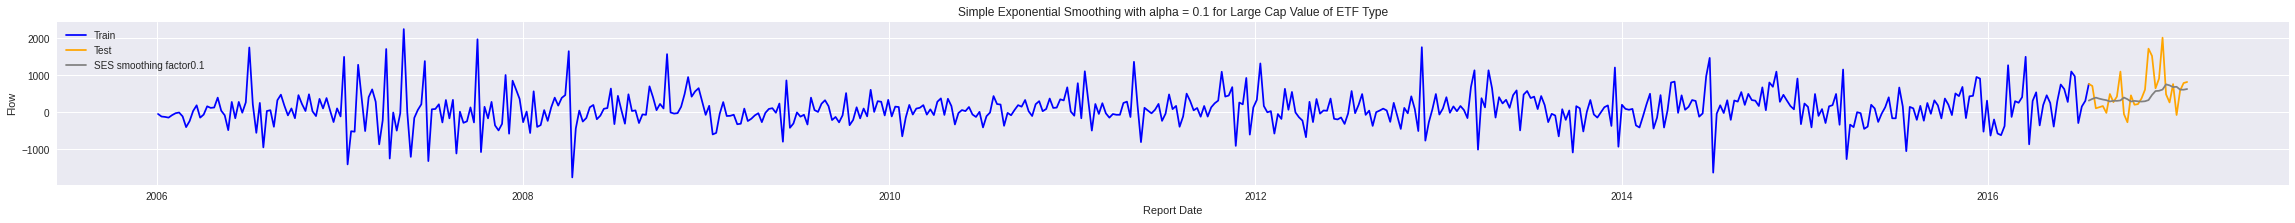

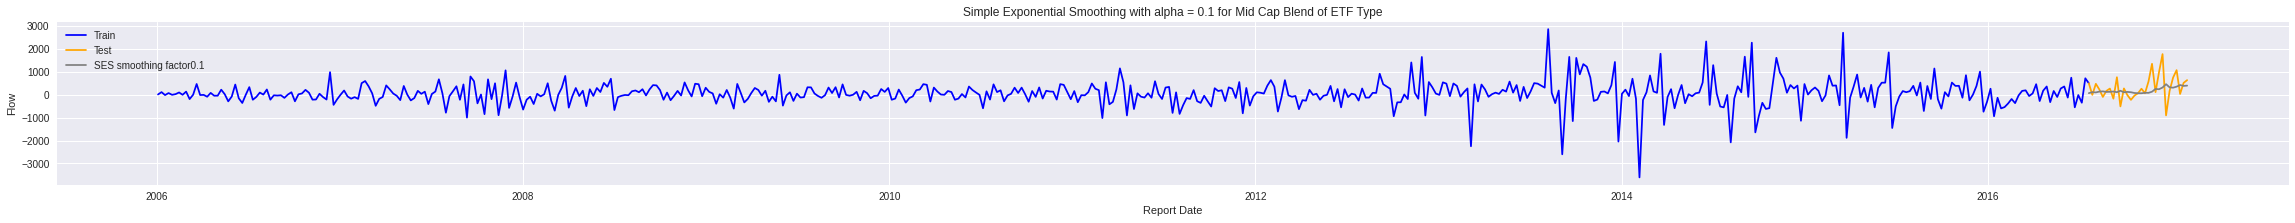

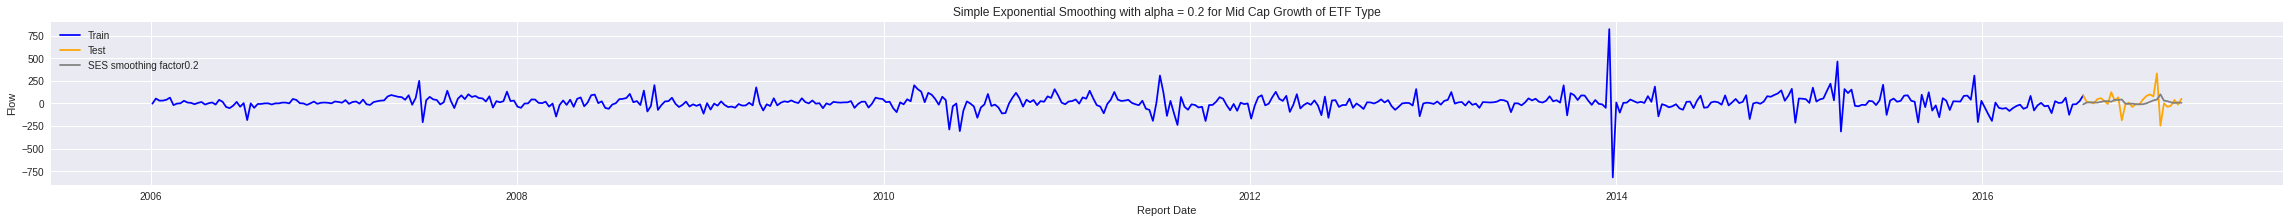

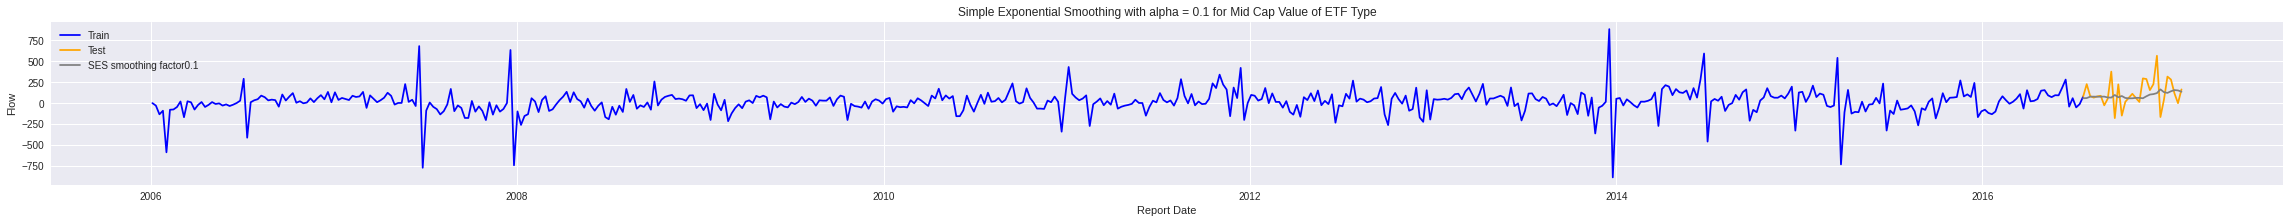

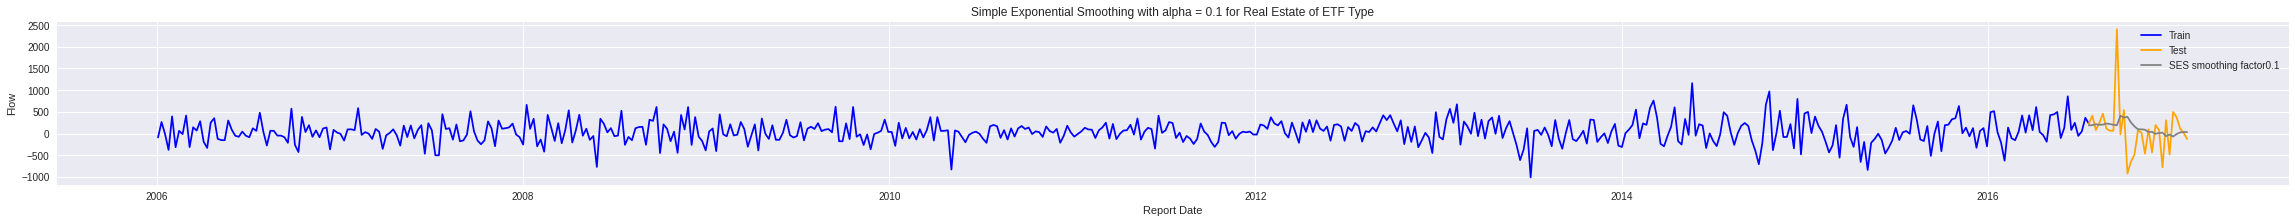

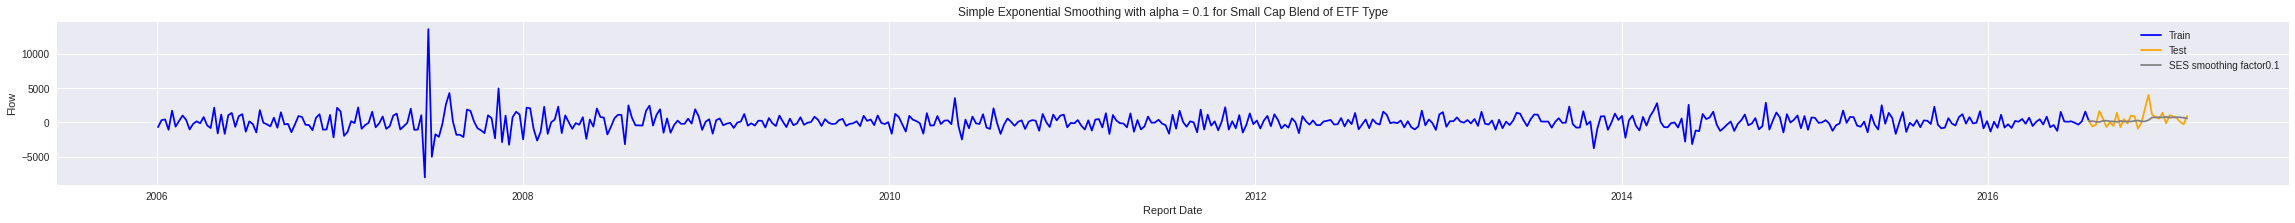

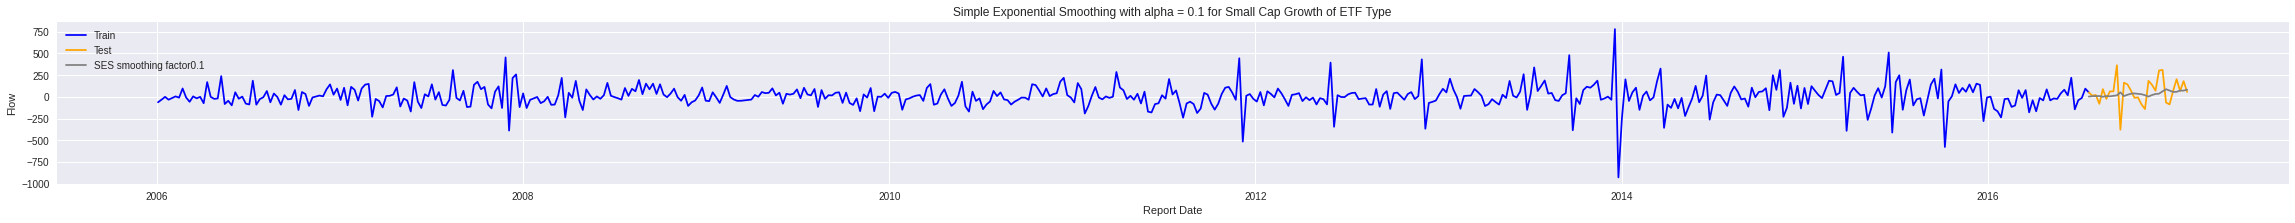

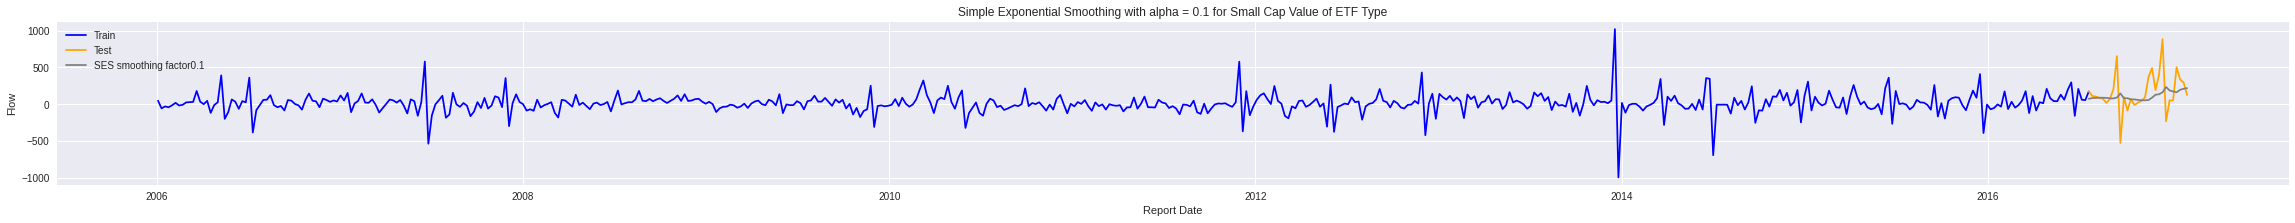

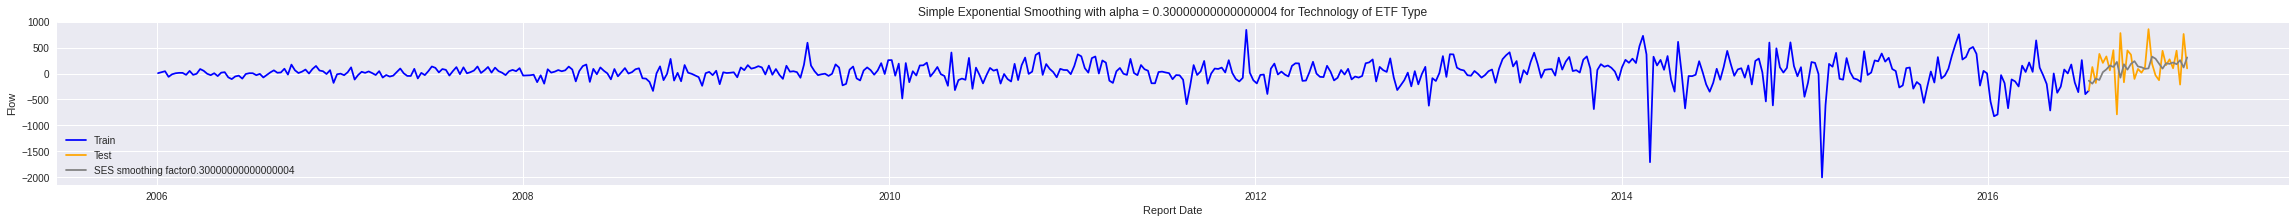

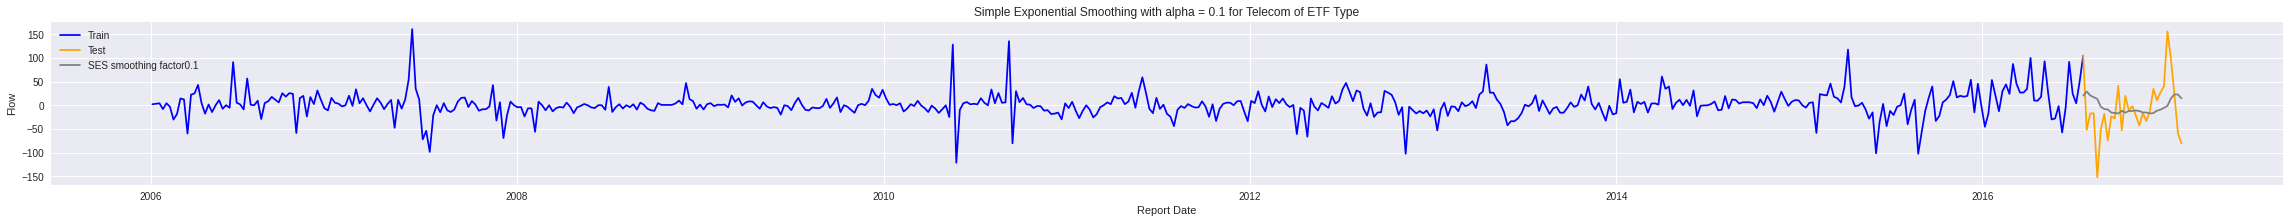

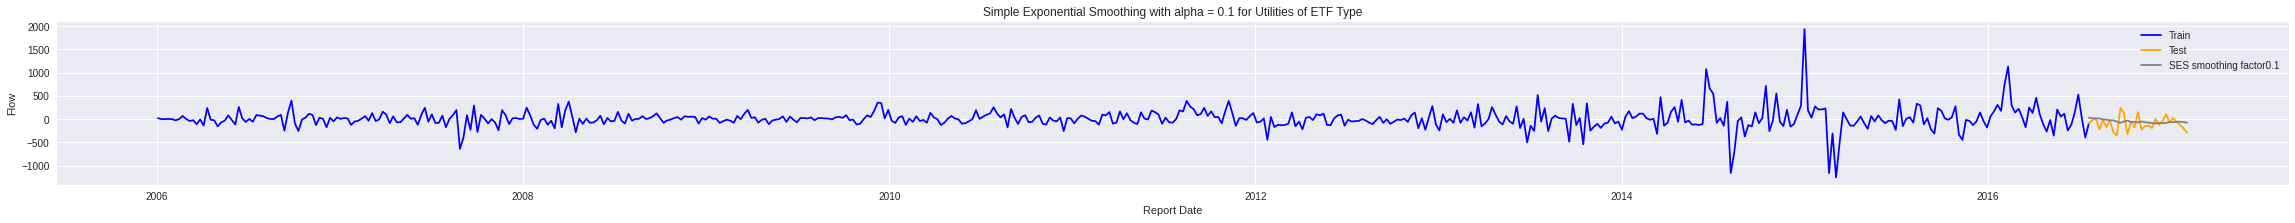

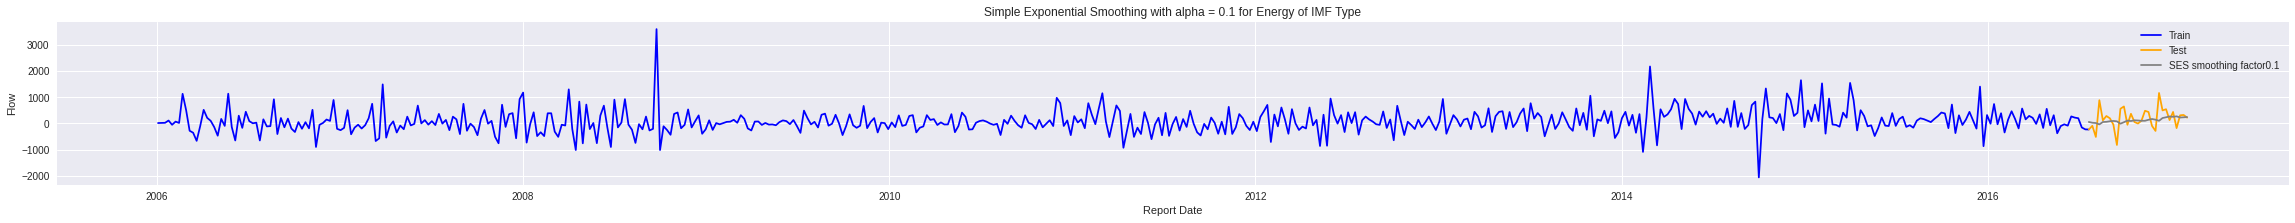

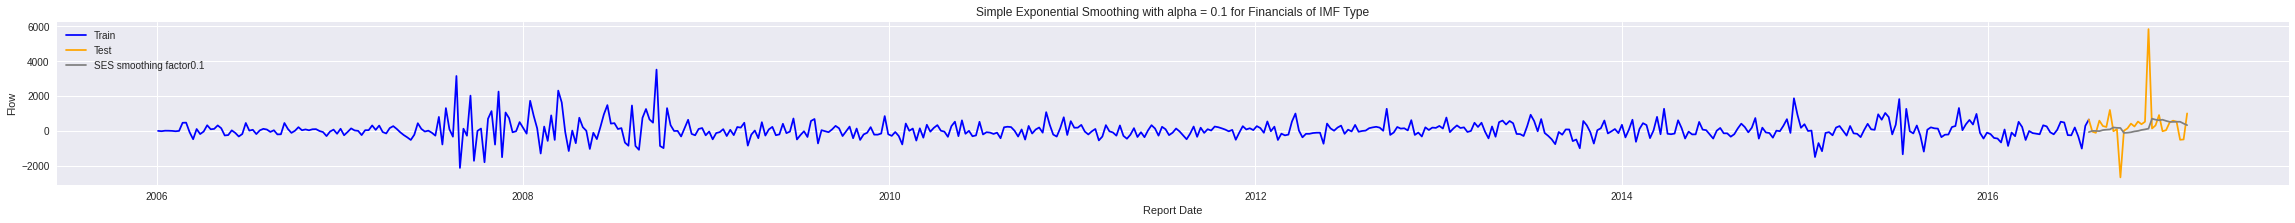

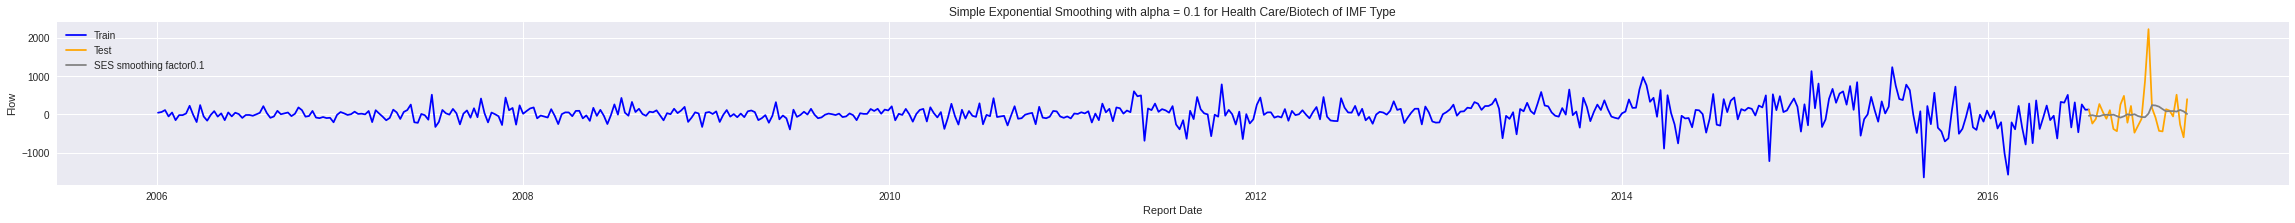

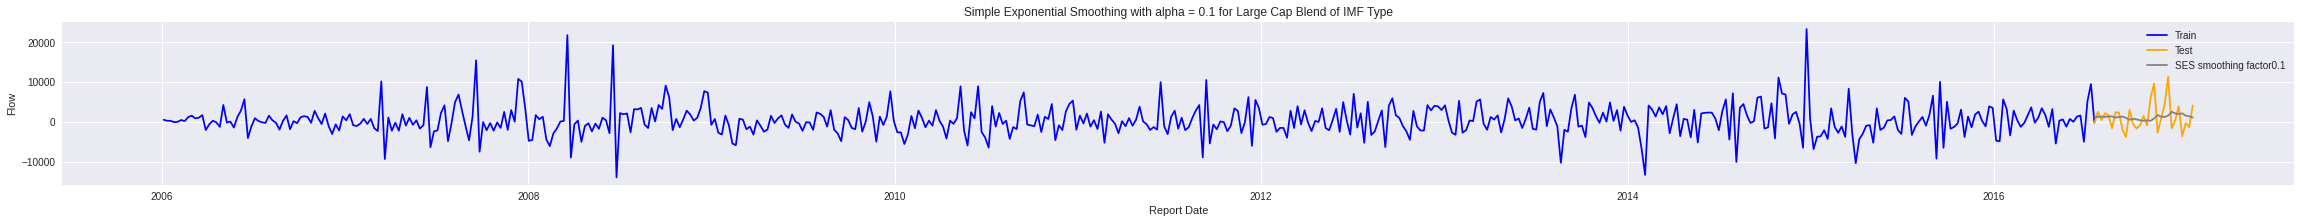

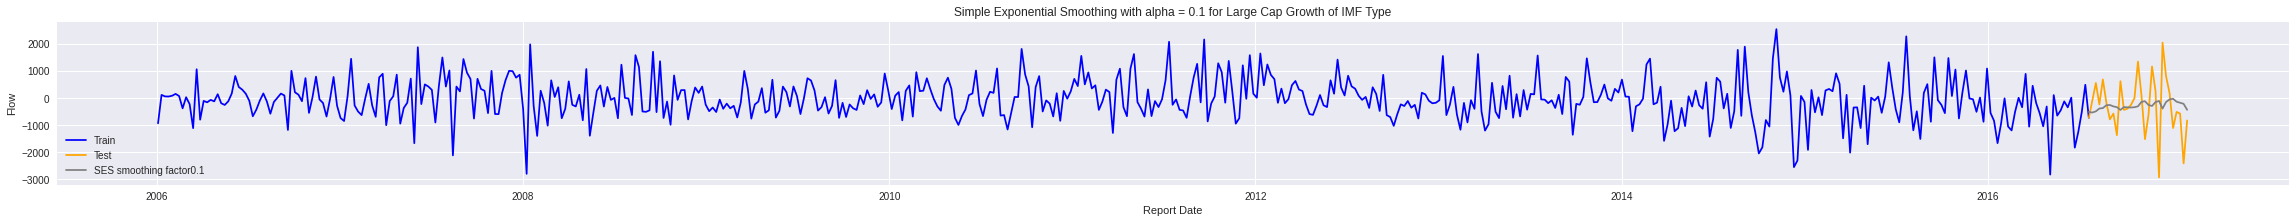

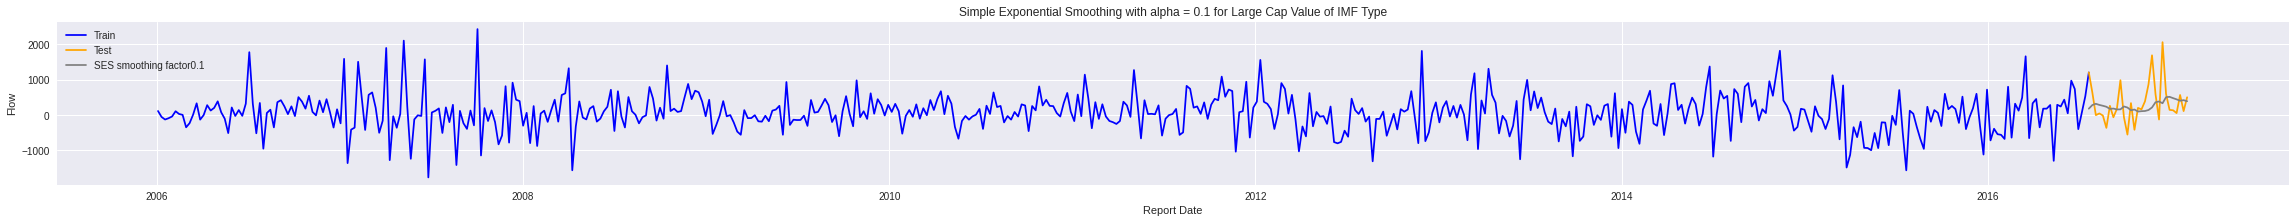

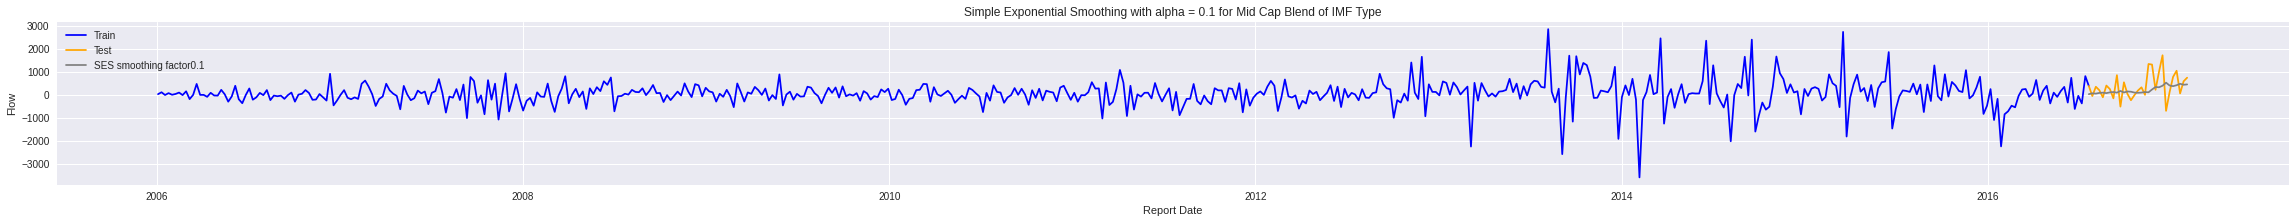

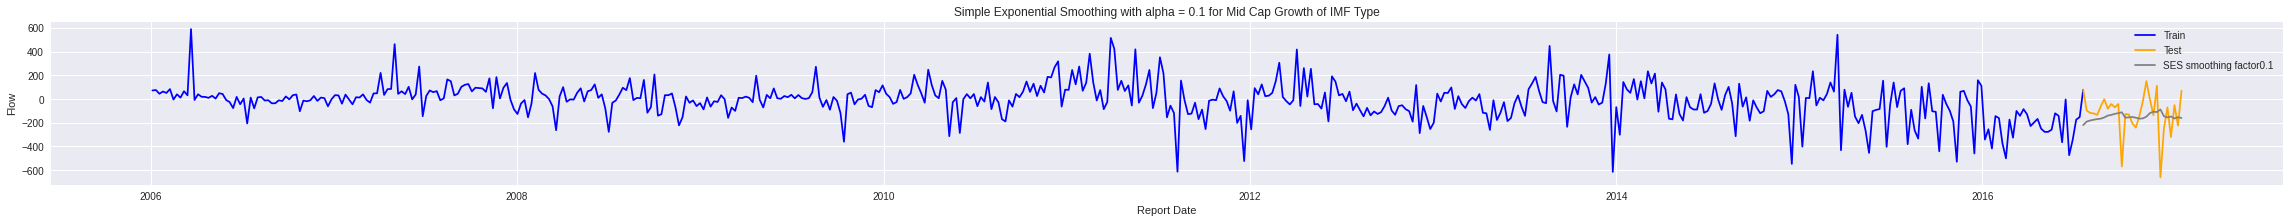

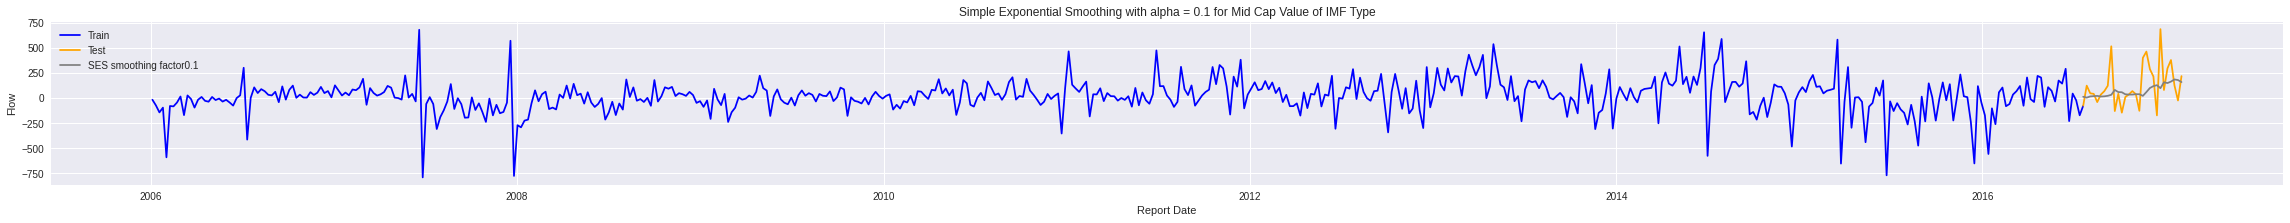

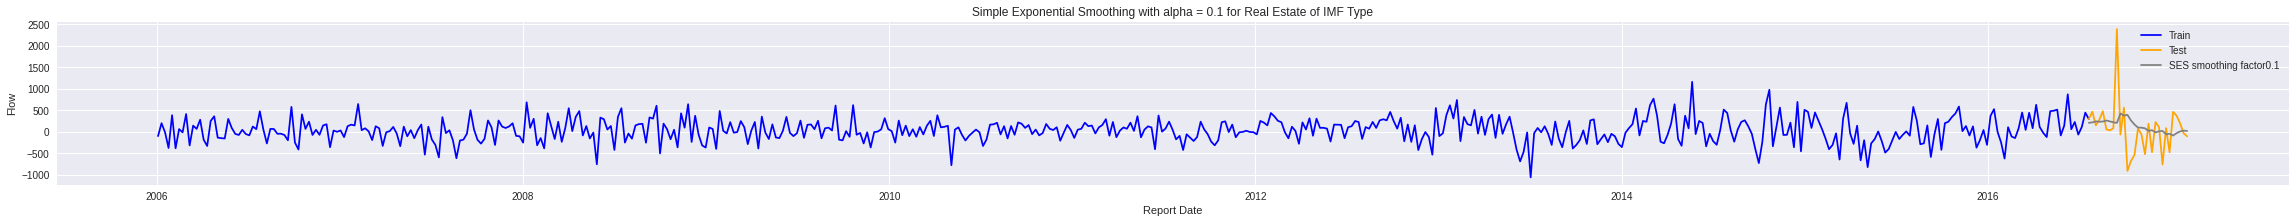

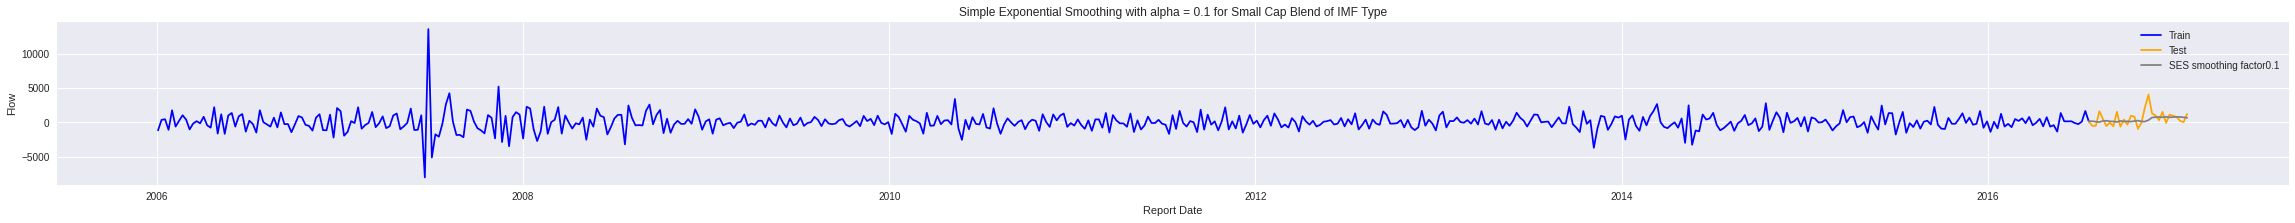

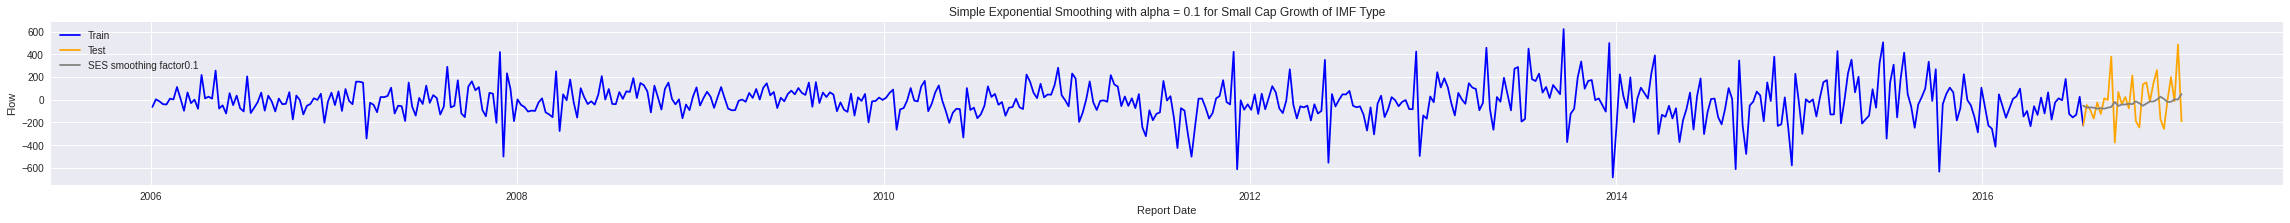

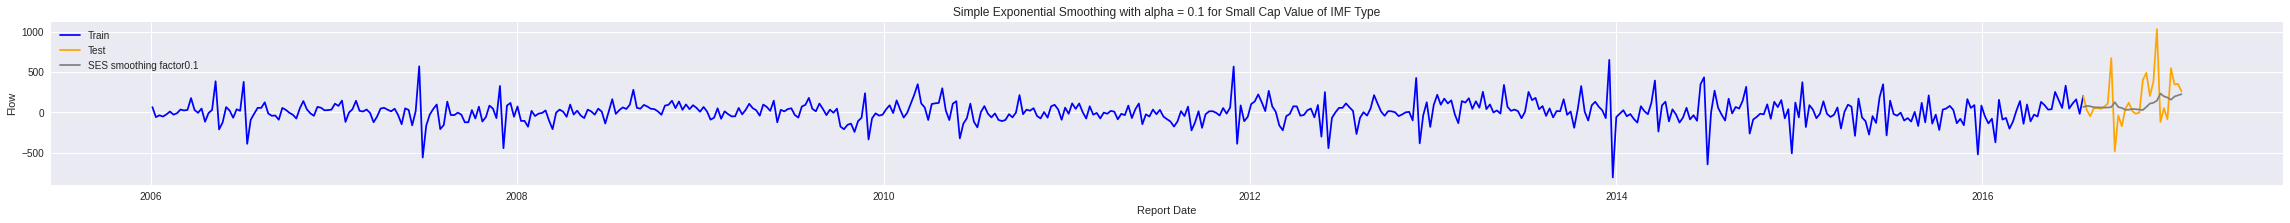

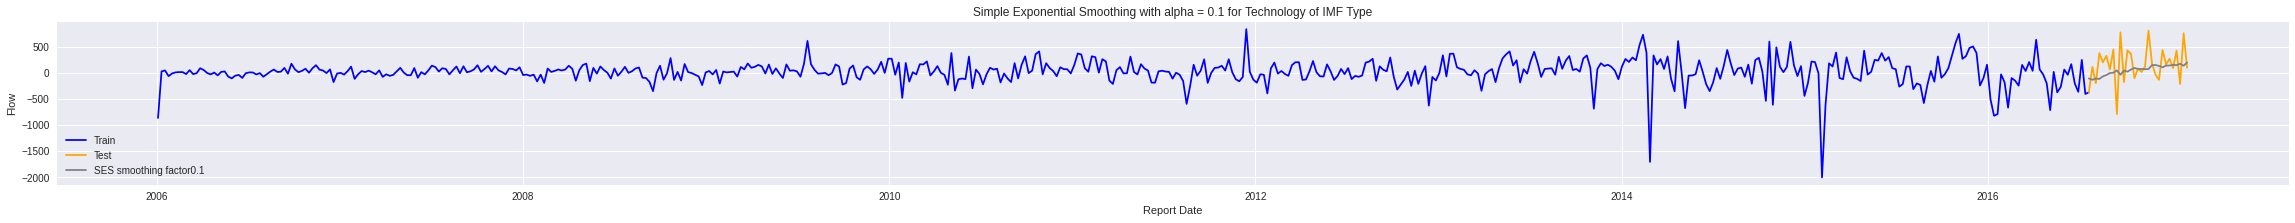

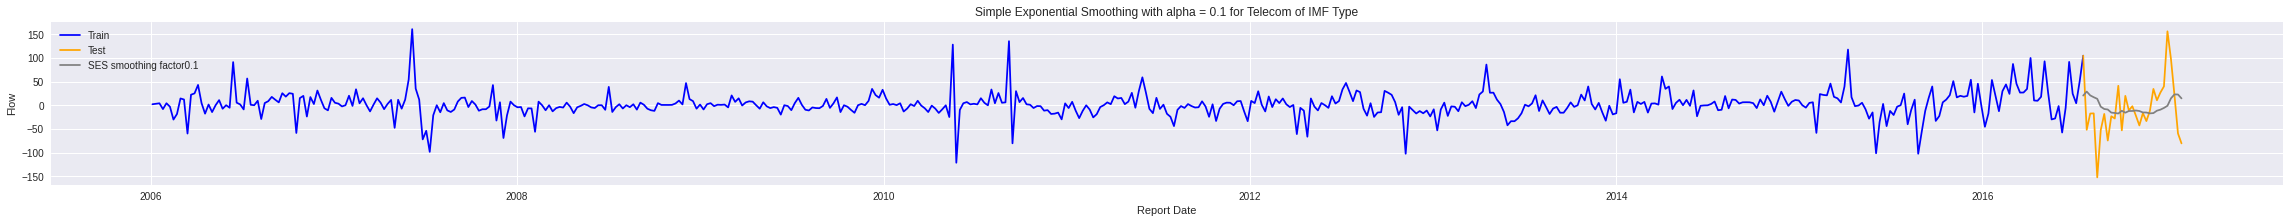

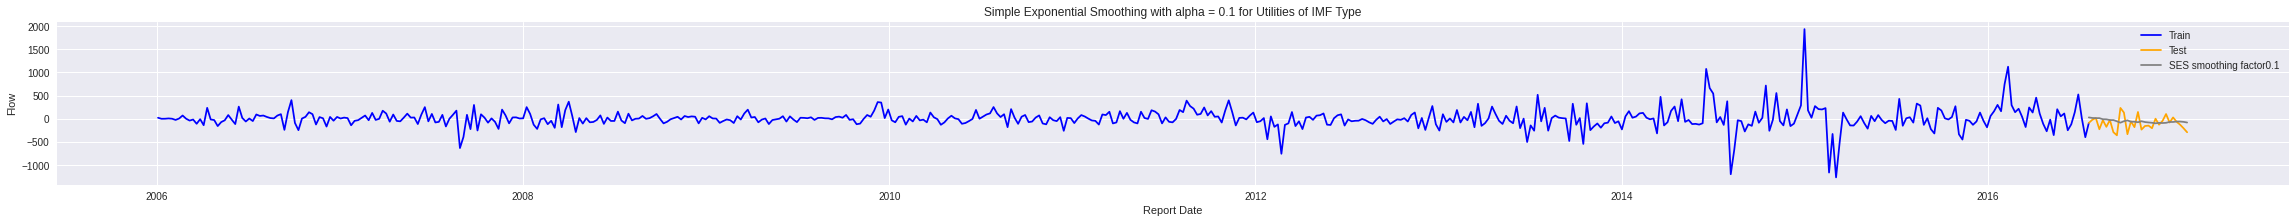

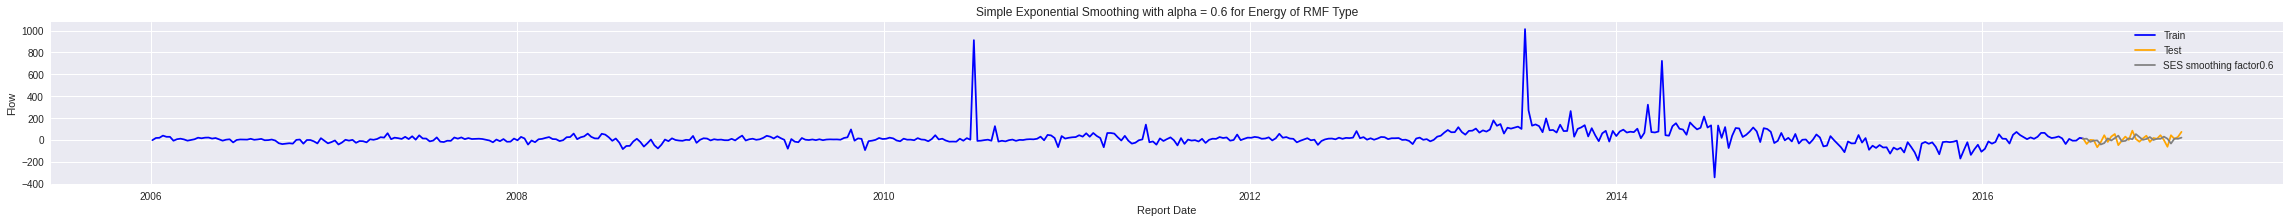

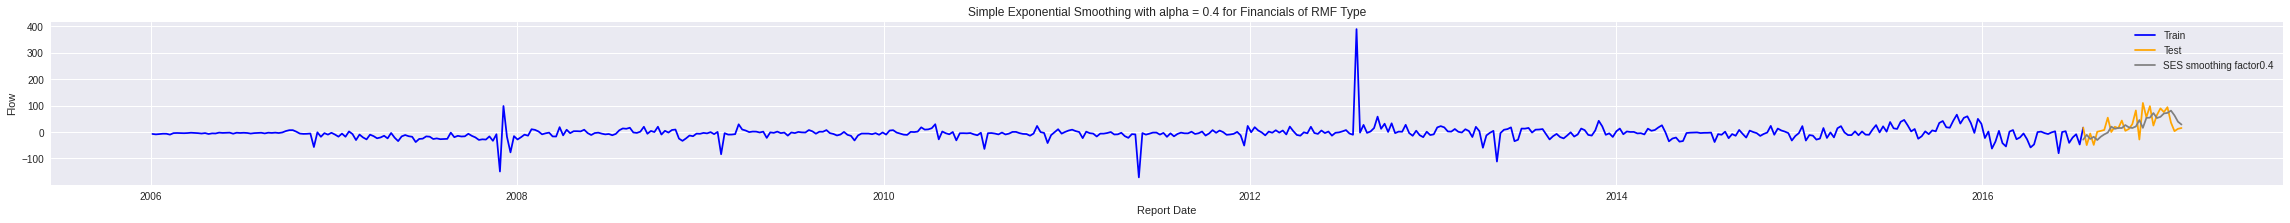

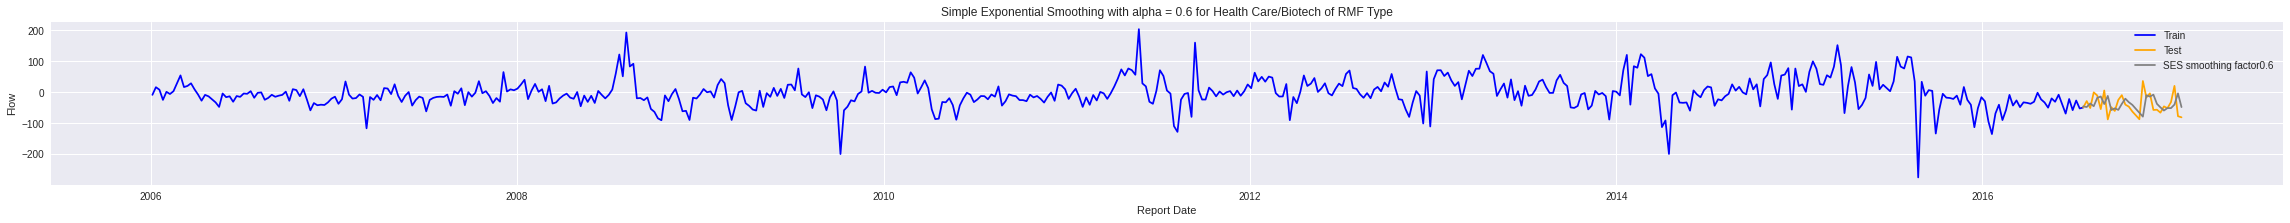

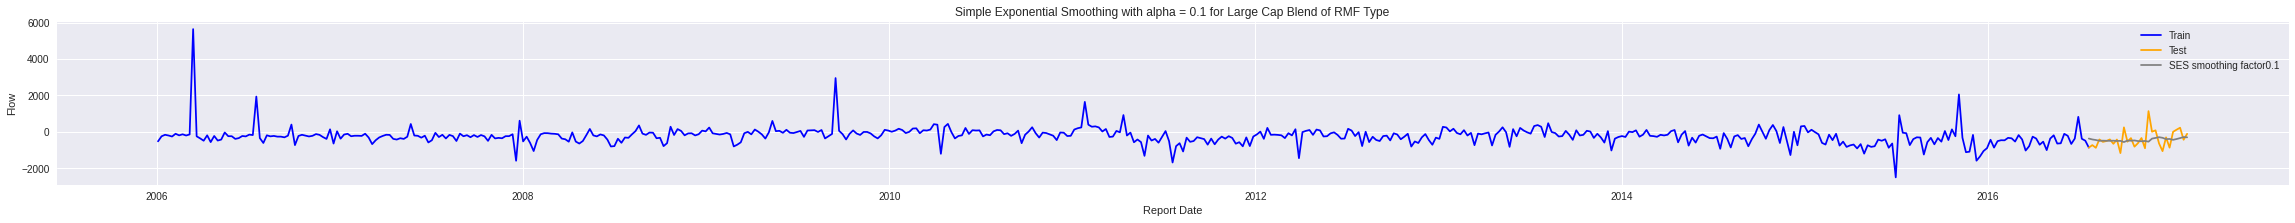

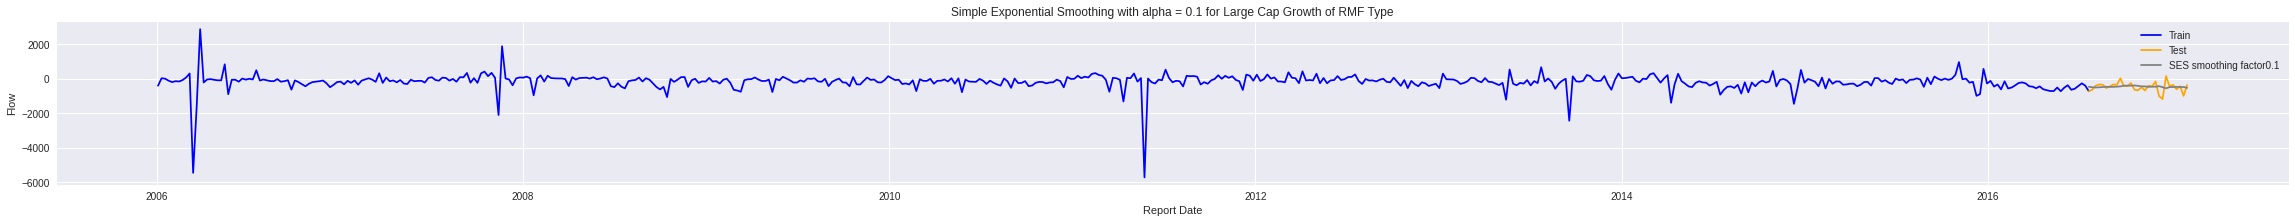

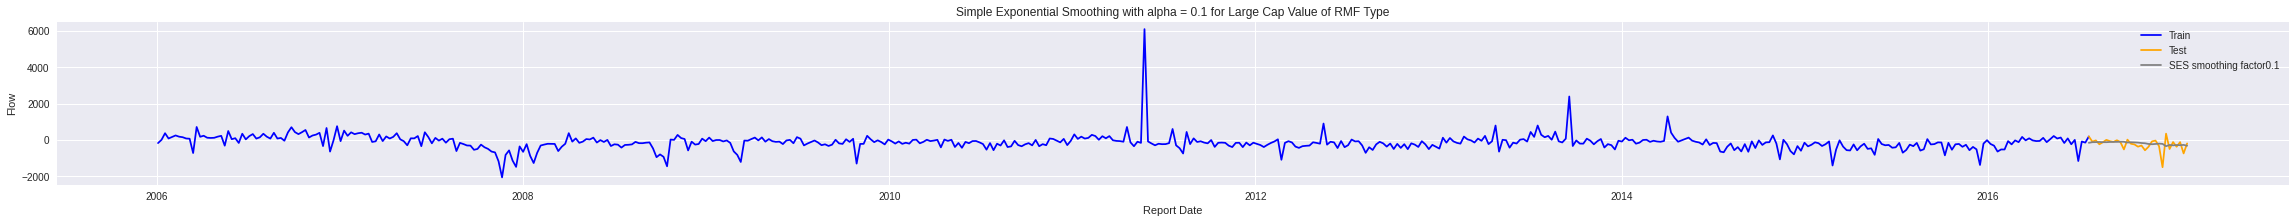

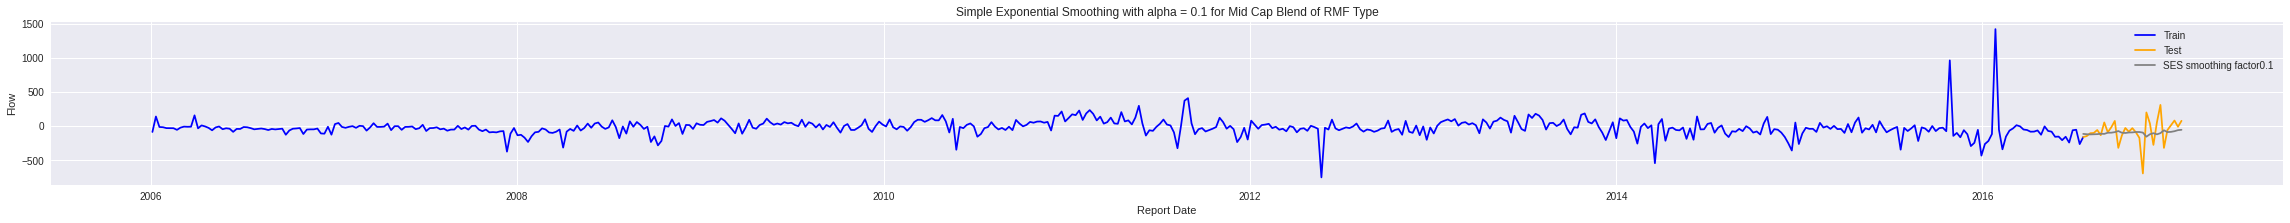

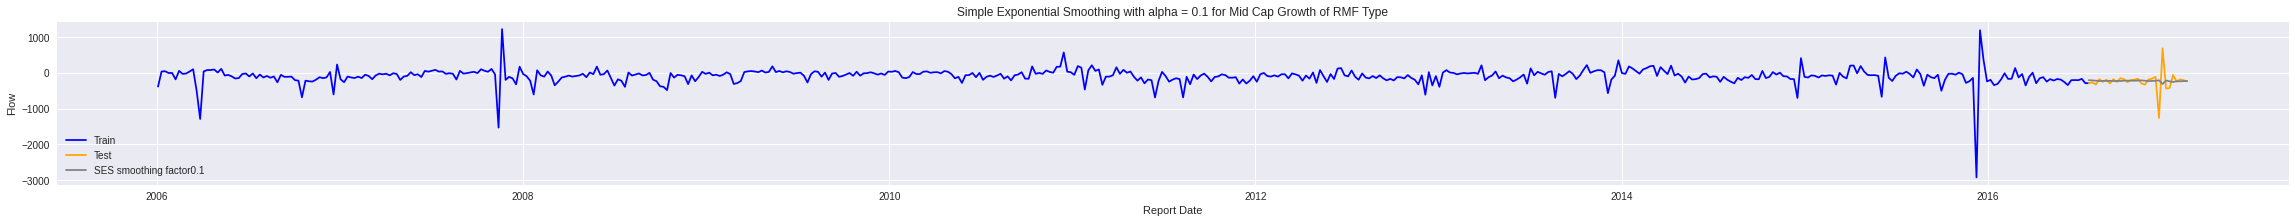

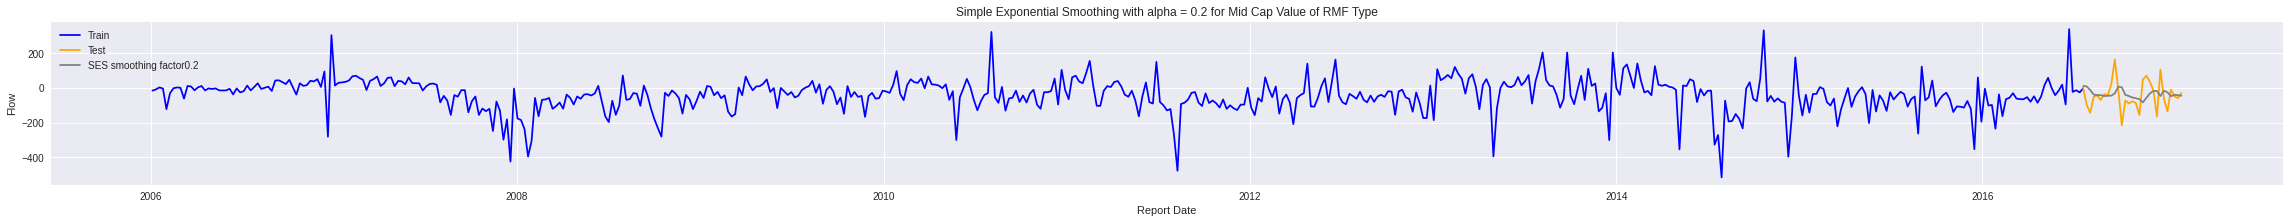

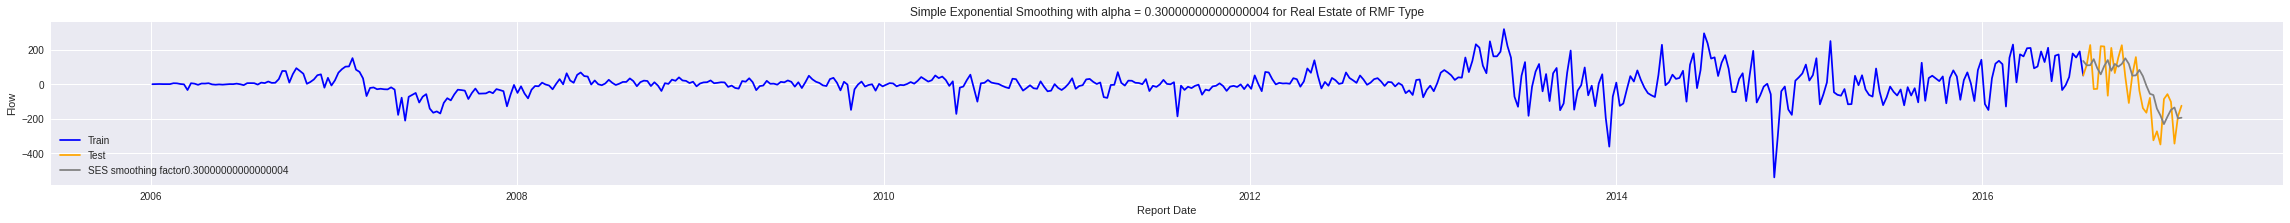

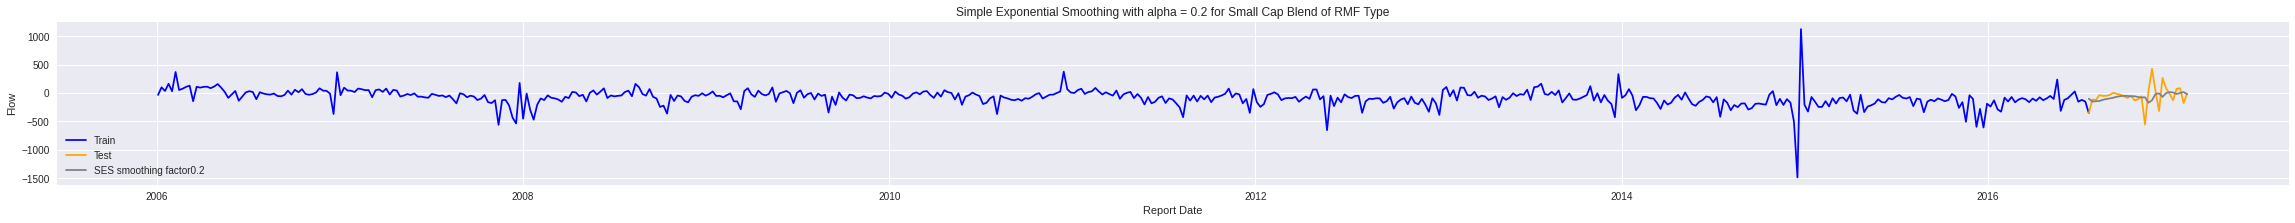

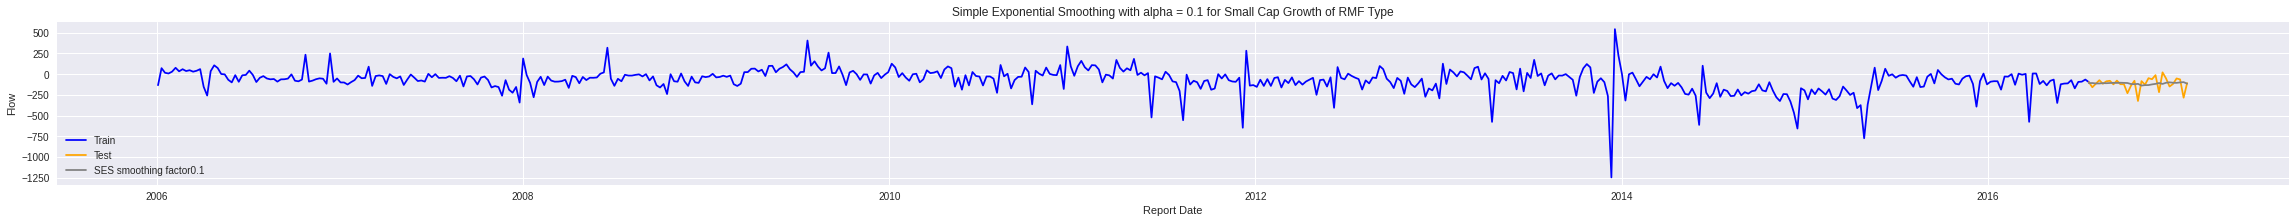

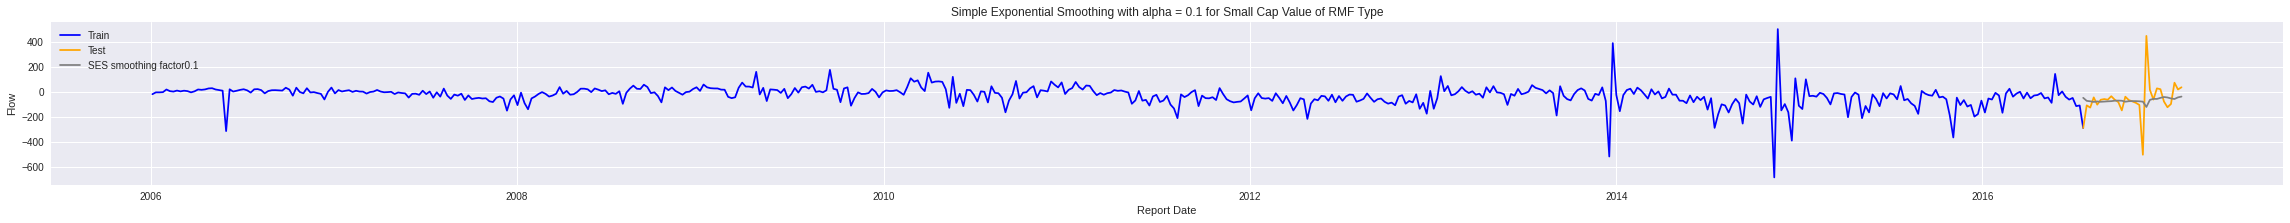

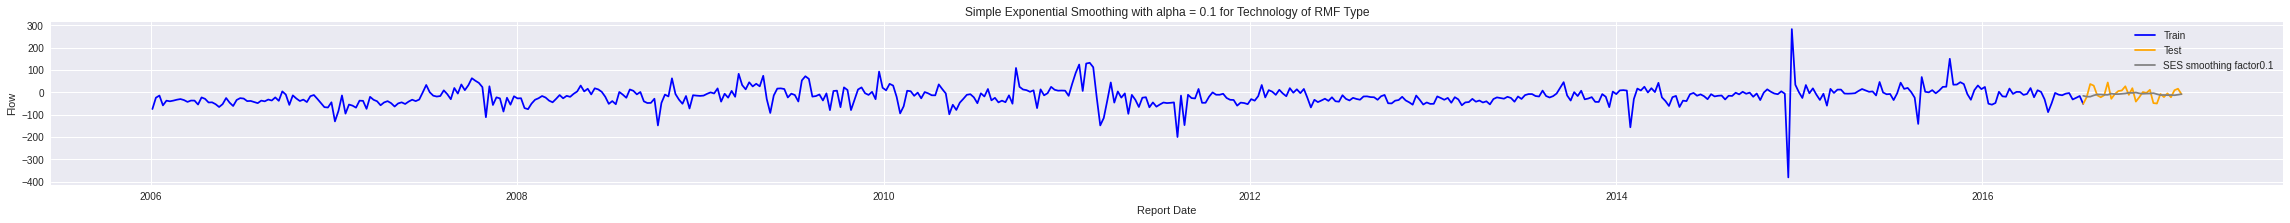

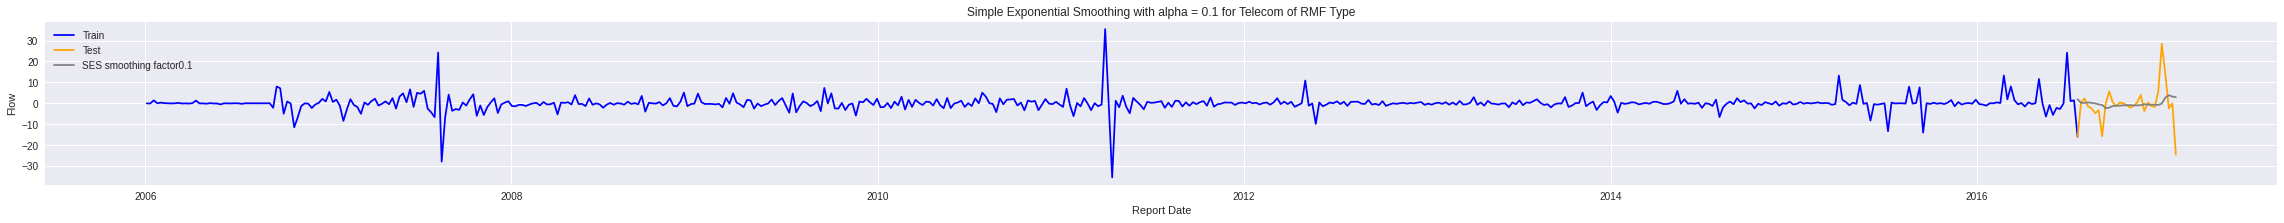

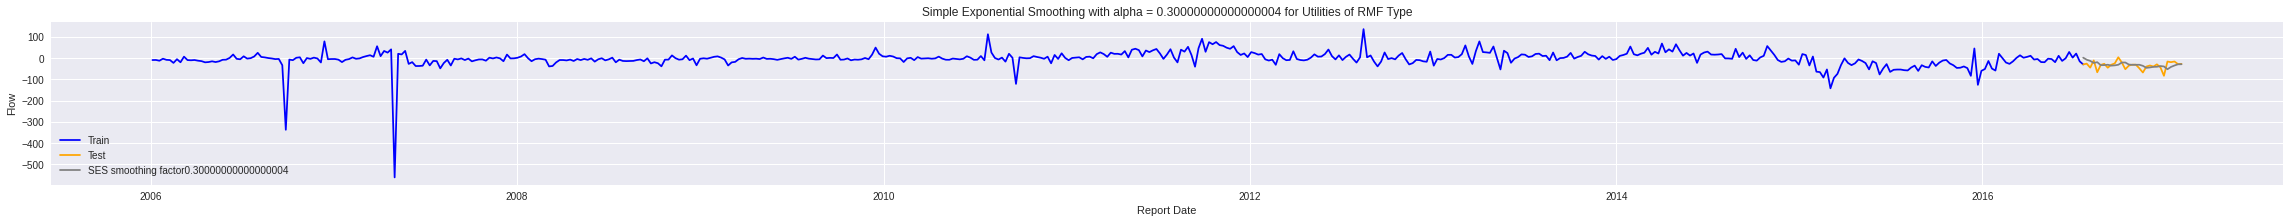

In [ ]:
# iterating for flow & SES smoothing factor saved in above dataframe
for i in range(df_ses_final.shape[0]):
  # subset 
  sub = data.loc[(data.Type == df_ses_final.iloc[i].Type) & (data.Industry == df_ses_final.iloc[i].Industry)][['ReportDate', 'Flow']]
  # reorder sequence
  sub.sort_values('ReportDate', ascending  = True, inplace=True)
  # train & test split
  train = sub.iloc[:551]
  test = sub.iloc[550:]
  # predict with best ses alpha
  pred_ses = ExponentialSmoothing(sub.Flow).fit(smoothing_level = df_ses_final.iloc[i]['SES alpha']).predict(550,)
  # plot
  plt.figure(figsize=(40,3))
  plt.plot(train.ReportDate, train.Flow, c = 'b', label = 'Train')
  plt.plot(test.ReportDate, test.Flow, c = 'orange', label = 'Test')
  ses_alpha = "SES smoothing factor" + str(df_ses_final.iloc[i]['SES alpha'])
  plt.plot(test.ReportDate, pred_ses, c = 'grey', label = ses_alpha)
  plt.title('Simple Exponential Smoothing with alpha = {} for {} of {} Type'.format(df_ses_final.iloc[i]['SES alpha'], df_ses_final.iloc[i]['Industry'], df_ses_final.iloc[i]['Type']))
  plt.xlabel('Report Date')
  plt.ylabel('Flow')
  plt.legend()
  plt.show()

In [ ]:
# if needed to store SES result
#df_ses_final.to_csv('ses_output.csv')

### Assess MA* vs SES*

In [ ]:
# compare two model result

comparision = df_ma_final.copy()
comparision[['SES alpha', 'SES_mse']] = df_ses_final[['SES alpha', 'SES mse']]
# comparision.drop(columns='SES mse', inplace=True)
comparision

Type             Industry  MA window        MA_mse  SES alpha       SES_mse
0   ETF               Energy         13  1.683463e+05        0.1  1.810559e+05
1   ETF           Financials         11  5.298055e+04        0.1  5.545442e+04
2   ETF  Health Care/Biotech         14  1.037090e+04        0.1  1.063216e+04
3   ETF      Large Cap Blend         20  3.255064e+06        0.1  3.374319e+06
4   ETF     Large Cap Growth         20  1.427495e+05        0.1  1.492183e+05
5   ETF      Large Cap Value         17  1.565841e+05        0.1  1.608566e+05
6   ETF        Mid Cap Blend         20  3.422931e+04        0.1  3.649100e+04
7   ETF       Mid Cap Growth          6  1.773055e+03        0.2  1.829638e+03
8   ETF        Mid Cap Value          9  2.273634e+04        0.1  2.339144e+04
9   ETF          Real Estate         18  4.950357e+04        0.1  5.241447e+04
10  ETF      Small Cap Blend         19  1.068476e+06        0.1  1.144424e+06
11  ETF     Small Cap Growth         20  6.899885e+03        0.1  7.163444e+03
12  ETF      Small Cap Value          8  2.043102e+04        0.1  2.144024e+04
13  ETF           Technology          7  1.866661e+03        0.3  1.968853e+03
14  ETF              Telecom         16  6.866296e+02        0.1  7.368029e+02
15  ETF            Utilities         15  8.215396e+03        0.1  8.744426e+03
16  IMF               Energy         13  1.683224e+05        0.1  1.810334e+05
17  IMF           Financials         11  5.297828e+04        0.1  5.545295e+04
18  IMF  Health Care/Biotech         14  1.045610e+04        0.1  1.069554e+04
19  IMF      Large Cap Blend         18  3.307342e+06        0.1  3.441461e+06
20  IMF     Large Cap Growth         20  2.041235e+05        0.1  2.163060e+05
21  IMF      Large Cap Value         17  1.566027e+05        0.1  1.631840e+05
22  IMF        Mid Cap Blend         20  3.241088e+04        0.1  3.417704e+04
23  IMF       Mid Cap Growth         10  1.419618e+04        0.1  1.430911e+04
24  IMF        Mid Cap Value          9  2.302436e+04        0.1  2.381932e+04
25  IMF          Real Estate         14  5.037292e+04        0.1  5.334851e+04
26  IMF      Small Cap Blend         19  1.110367e+06        0.1  1.191332e+06
27  IMF     Small Cap Growth         17  9.586868e+03        0.1  9.798641e+03
28  IMF      Small Cap Value          8  2.132454e+04        0.1  2.232227e+04
29  IMF           Technology          4  2.795837e+04        0.1  2.830879e+04
30  IMF              Telecom         16  6.866296e+02        0.1  7.368029e+02
31  IMF            Utilities         15  8.316653e+03        0.1  8.790759e+03
32  RMF               Energy          2  1.613458e+02        0.6  1.516567e+02
33  RMF           Financials          4  3.215849e+00        0.4  3.168411e+00
34  RMF  Health Care/Biotech          2  3.452898e+02        0.6  3.171519e+02
35  RMF      Large Cap Blend         18  1.380561e+06        0.1  1.443019e+06
36  RMF     Large Cap Growth         20  1.528636e+06        0.1  1.574836e+06
37  RMF      Large Cap Value         13  6.658096e+04        0.1  7.028869e+04
38  RMF        Mid Cap Blend         15  2.717574e+03        0.1  2.776529e+03
39  RMF       Mid Cap Growth         20  7.562105e+04        0.1  7.665091e+04
40  RMF        Mid Cap Value          5  7.790957e+02        0.2  8.191287e+02
41  RMF          Real Estate          8  6.181676e+01        0.3  6.632460e+01
42  RMF      Small Cap Blend          4  9.949174e+03        0.2  1.015928e+04
43  RMF     Small Cap Growth         15  6.799021e+03        0.1  6.947379e+03
44  RMF      Small Cap Value         19  3.889656e+03        0.1  3.937471e+03
45  RMF           Technology         13  2.019848e+02        0.1  2.055814e+02
46  RMF              Telecom          6  1.619449e-01        0.1  1.530775e-01
47  RMF            Utilities          4  7.684388e+01        0.3  6.982098e+01

In [ ]:
comparision['better model'] = np.where(comparision['MA_mse'] > comparision['SES_mse'], 'SES', 'MA')
comparision

Type             Industry  MA window        MA_mse  SES alpha  \
0   ETF               Energy         13  1.683463e+05        0.1   
1   ETF           Financials         11  5.298055e+04        0.1   
2   ETF  Health Care/Biotech         14  1.037090e+04        0.1   
3   ETF      Large Cap Blend         20  3.255064e+06        0.1   
4   ETF     Large Cap Growth         20  1.427495e+05        0.1   
5   ETF      Large Cap Value         17  1.565841e+05        0.1   
6   ETF        Mid Cap Blend         20  3.422931e+04        0.1   
7   ETF       Mid Cap Growth          6  1.773055e+03        0.2   
8   ETF        Mid Cap Value          9  2.273634e+04        0.1   
9   ETF          Real Estate         18  4.950357e+04        0.1   
10  ETF      Small Cap Blend         19  1.068476e+06        0.1   
11  ETF     Small Cap Growth         20  6.899885e+03        0.1   
12  ETF      Small Cap Value          8  2.043102e+04        0.1   
13  ETF           Technology          7  1.866661e+03        0.3   
14  ETF              Telecom         16  6.866296e+02        0.1   
15  ETF            Utilities         15  8.215396e+03        0.1   
16  IMF               Energy         13  1.683224e+05        0.1   
17  IMF           Financials         11  5.297828e+04        0.1   
18  IMF  Health Care/Biotech         14  1.045610e+04        0.1   
19  IMF      Large Cap Blend         18  3.307342e+06        0.1   
20  IMF     Large Cap Growth         20  2.041235e+05        0.1   
21  IMF      Large Cap Value         17  1.566027e+05        0.1   
22  IMF        Mid Cap Blend         20  3.241088e+04        0.1   
23  IMF       Mid Cap Growth         10  1.419618e+04        0.1   
24  IMF        Mid Cap Value          9  2.302436e+04        0.1   
25  IMF          Real Estate         14  5.037292e+04        0.1   
26  IMF      Small Cap Blend         19  1.110367e+06        0.1   
27  IMF     Small Cap Growth         17  9.586868e+03        0.1   
28  IMF      Small Cap Value          8  2.132454e+04        0.1   
29  IMF           Technology          4  2.795837e+04        0.1   
30  IMF              Telecom         16  6.866296e+02        0.1   
31  IMF            Utilities         15  8.316653e+03        0.1   
32  RMF               Energy          2  1.613458e+02        0.6   
33  RMF           Financials          4  3.215849e+00        0.4   
34  RMF  Health Care/Biotech          2  3.452898e+02        0.6   
35  RMF      Large Cap Blend         18  1.380561e+06        0.1   
36  RMF     Large Cap Growth         20  1.528636e+06        0.1   
37  RMF      Large Cap Value         13  6.658096e+04        0.1   
38  RMF        Mid Cap Blend         15  2.717574e+03        0.1   
39  RMF       Mid Cap Growth         20  7.562105e+04        0.1   
40  RMF        Mid Cap Value          5  7.790957e+02        0.2   
41  RMF          Real Estate          8  6.181676e+01        0.3   
42  RMF      Small Cap Blend          4  9.949174e+03        0.2   
43  RMF     Small Cap Growth         15  6.799021e+03        0.1   
44  RMF      Small Cap Value         19  3.889656e+03        0.1   
45  RMF           Technology         13  2.019848e+02        0.1   
46  RMF              Telecom          6  1.619449e-01        0.1   
47  RMF            Utilities          4  7.684388e+01        0.3   

         SES_mse better model  
0   1.810559e+05           MA  
1   5.545442e+04           MA  
2   1.063216e+04           MA  
3   3.374319e+06           MA  
4   1.492183e+05           MA  
5   1.608566e+05           MA  
6   3.649100e+04           MA  
7   1.829638e+03           MA  
8   2.339144e+04           MA  
9   5.241447e+04           MA  
10  1.144424e+06           MA  
11  7.163444e+03           MA  
12  2.144024e+04           MA  
13  1.968853e+03           MA  
14  7.368029e+02           MA  
15  8.744426e+03           MA  
16  1.810334e+05           MA  
17  5.545295e+04           MA  
18  1.069554e+04           MA  
19  3.441461e+06           MA 

In [ ]:
# overall MA models generate a better performance in predicting short-term flow change
comparision['better model'].value_counts()

MA     43
SES     5
Name: better model, dtype: int64

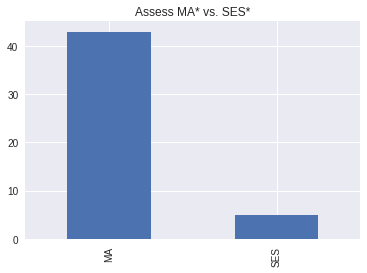

In [ ]:
# plot
comparision['better model'].value_counts().plot(kind = 'bar')
plt.title('Assess MA* vs. SES*')
plt.show()